In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from datetime import datetime
import pickle
import os
import json
import seaborn as sns

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class RelativePositionEncoding(nn.Module):
    """
    Learnable relative position encoding for features in the transformer model.
    This allows the model to understand relationships between features based on their positions.
    """
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        # Create a learnable embedding for relative positions
        self.rel_pos_embedding = nn.Parameter(torch.randn(2 * max_seq_len - 1, d_model))
        self.max_seq_len = max_seq_len
        
    def forward(self, x):
        """
        Apply relative positional encodings to the input.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            
        Returns:
            Tensor with relative positional information.
        """
        seq_len = x.size(1)
        # Create position indices matrix
        pos_indices = torch.arange(seq_len, device=x.device)
        # Calculate relative positions: for each position i, calculate its relative distance to each position j
        rel_pos_indices = pos_indices.unsqueeze(1) - pos_indices.unsqueeze(0) + self.max_seq_len - 1
        
        # Get embeddings for each relative position
        rel_pos_encoded = self.rel_pos_embedding[rel_pos_indices]
        
        return rel_pos_encoded

In [5]:
class MultiHeadAttentionWithRelPos(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    """
    def __init__(self, d_model, num_heads, dropout=0.1, max_seq_len=1000):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Relative position encoding
        self.rel_pos_encoding = RelativePositionEncoding(max_seq_len, d_model)
        
        # Separate linear projection for relative position attention
        self.rel_pos_proj = nn.Linear(d_model, d_model)
        
        # Scaling factor for dot product attention
        self.scale = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, key_padding_mask=None, need_weights=False):
        """
        Forward pass with relative positional encoding.
        
        Args:
            query, key, value: Input tensors [batch_size, seq_len, d_model]
            key_padding_mask: Mask for padded values [batch_size, seq_len]
            need_weights: Whether to return attention weights
            
        Returns:
            Output tensor and optionally attention weights
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        # Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute content-based attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [batch, heads, seq_len, seq_len]
        
        # Create relative position bias
        # We'll use a simpler approach that's more efficient and avoids shape mismatches
        rel_bias = torch.zeros((seq_len, seq_len), device=query.device)
        positions = torch.arange(seq_len, device=query.device)
        relative_positions = positions.unsqueeze(1) - positions.unsqueeze(0)
        
        # Convert to a simple positional bias (closer = higher attention)
        rel_bias = -torch.abs(relative_positions) * 0.1
        
        # Add the positional bias to the attention scores
        # We add the same bias for all heads and batches
        attn_scores = attn_scores + rel_bias.unsqueeze(0).unsqueeze(0)
        
        # Apply mask if provided
        if key_padding_mask is not None:
            # Convert mask to attention mask (True = ignore)
            attn_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            attn_scores = attn_scores.masked_fill(attn_mask, float('-inf'))
        
        # Apply softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention weights to values
        output = torch.matmul(attn_weights, v)  # [batch, heads, seq_len, head_dim]
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # Final linear projection
        output = self.out_proj(output)
        
        if need_weights:
            return output, attn_weights
        else:
            return output


In [6]:
class RelativePositionTransformerLayer(nn.Module):
    """
    Transformer encoder layer with relative positional encoding.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, 
                 activation="gelu", max_seq_len=1000, norm_first=True):
        super().__init__()
        
        # Multi-head attention with relative position encoding
        self.self_attn = MultiHeadAttentionWithRelPos(
            d_model, nhead, dropout=dropout, max_seq_len=max_seq_len
        )
        
        # Feedforward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        # Normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # Activation function
        self.activation = getattr(nn.functional, activation)
        self.norm_first = norm_first
        
    def forward(self, src, src_key_padding_mask=None):
        """
        Forward pass of the transformer layer.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            src_key_padding_mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Processed tensor
        """
        # Pre-norm architecture
        if self.norm_first:
            # Multi-head attention block with pre-normalization
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2, key_padding_mask=src_key_padding_mask)
            src = src + self.dropout1(src2)
            
            # Feedforward block with pre-normalization
            src2 = self.norm2(src)
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
            src = src + self.dropout2(src2)
        else:
            # Multi-head attention block with post-normalization
            src2 = self.self_attn(src, src, src, key_padding_mask=src_key_padding_mask)
            src = self.norm1(src + self.dropout1(src2))
            
            # Feedforward block with post-normalization
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
            src = self.norm2(src + self.dropout2(src2))
            
        return src

In [7]:
class RelativePositionTransformerEncoder(nn.Module):
    """
    Transformer encoder with relative positional encoding.
    """
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        
    def forward(self, src, mask=None):
        """
        Forward pass of the transformer encoder.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Encoded tensor
        """
        output = src
        for layer in self.layers:
            output = layer(output, src_key_padding_mask=mask)
        return output

In [8]:
class TabularTransformerWithRelPos(nn.Module):
    """
    Transformer model for tabular data with relative positional encoding.
    """
    def __init__(self, 
                 num_features, 
                 d_model=128, 
                 nhead=8, 
                 num_layers=3, 
                 dim_feedforward=512, 
                 dropout=0.1, 
                 activation='gelu',
                 max_seq_len=1000):
        super().__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        
        # Enhanced feature value embedding
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),  # Lower initial dropout
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Feature interaction module
        self.feature_interaction = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        
        # Column embedding (learnable)
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        # Layer normalization before transformer
        self.norm = nn.LayerNorm(d_model)
        
        # Create encoder layer with relative position encoding
        encoder_layer = RelativePositionTransformerLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            max_seq_len=max_seq_len,
            norm_first=True
        )
        
        # Create transformer encoder
        self.transformer_encoder = RelativePositionTransformerEncoder(encoder_layer, num_layers)
        
        # Enhanced output projection with skip connection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def _generate_attention_mask(self, mask):
        """Generate attention mask for transformer"""
        if mask is None:
            return None
        # Convert binary mask to attention mask (1 = don't attend, 0 = attend)
        attn_mask = mask.bool()
        return attn_mask
                
    def forward(self, x, column_indices, mask=None):
        """
        Forward pass of the transformer model with relative position encoding.
        
        Args:
            x: Input tensor [batch_size, num_features]
            column_indices: Tensor of column indices [num_features]
            mask: Optional mask for missing values [batch_size, num_features]
            
        Returns:
            Tensor of predicted values [batch_size, num_features]
        """
        batch_size = x.size(0)
        
        # Reshape to [batch_size, num_features, 1] for embedding
        x = x.unsqueeze(-1)
        
        # Embed feature values
        x_embedded = self.value_embedding(x)
        
        # Add column embeddings
        col_embed = self.column_embedding(column_indices).unsqueeze(0).expand(batch_size, -1, -1)
        x_embedded = x_embedded + col_embed
        
        # Apply feature interaction
        x_interacted = self.feature_interaction(x_embedded)
        x_embedded = x_embedded + x_interacted  # Residual connection
        
        # Apply layer normalization
        x_embedded = self.norm(x_embedded)
        
        # Generate attention mask if needed
        attn_mask = self._generate_attention_mask(mask) if mask is not None else None
        
        # Pass through transformer encoder with relative position encoding
        x_encoded = self.transformer_encoder(x_embedded, attn_mask)
        
        # Project to output
        output = self.output_projection(x_encoded).squeeze(-1)
        
        return output

In [9]:
class EnsembleModel(nn.Module):
    """
    Ensemble of transformer models for improved prediction.
    """
    def __init__(self, num_features, config, num_models=3):
        super().__init__()
        self.num_models = num_models
        
        # Create multiple base models
        self.models = nn.ModuleList([
            TabularTransformerWithRelPos(
                num_features=num_features,
                d_model=config["d_model"],
                nhead=config["num_heads"],
                num_layers=config["num_layers"],
                dim_feedforward=config["dim_feedforward"],
                dropout=config["dropout"],
                activation=config["activation"],
                max_seq_len=max(2 * num_features, 100)
            ) for _ in range(num_models)
        ])
        
    def forward(self, x, column_indices, mask=None):
        # Get predictions from all models
        all_preds = []
        for model in self.models:
            preds = model(x, column_indices, mask)
            all_preds.append(preds.unsqueeze(0))
        
        # Stack and average predictions
        all_preds = torch.cat(all_preds, dim=0)
        avg_preds = torch.mean(all_preds, dim=0)
        
        return avg_preds

In [10]:
def create_missing_mask(data, missing_fraction=0.2, mechanism="MCAR"):
    """
    Create a mask for missing values using different mechanisms.
    
    Args:
        data (torch.Tensor): Input data tensor
        missing_fraction (float): Fraction of values to mask
        mechanism (str): One of "MCAR", "MAR", or "MNAR"
        
    Returns:
        torch.Tensor: Binary mask (1 = missing, 0 = present)
    """
    try:
        # MCAR implementation - completely random
        if mechanism == "MCAR":
            mask = torch.rand(data.shape, device=data.device) < missing_fraction
            return mask.int()
        
        # Simulated MAR (missing at random) implementation
        # In MAR, missingness depends on observed values but not on missing values
        elif mechanism == "MAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # Number of features
            num_features = data.shape[1]
            
            # For each column, make missingness depend on values in other columns
            for col_idx in range(num_features):
                # Choose a different column as predictor (wrapping around if needed)
                predictor_col = (col_idx + 1) % num_features
                
                # Get predictor values
                predictor_values = data[:, predictor_col]
                
                # Normalize predictor values to [0, 1] range
                if predictor_values.max() > predictor_values.min():
                    normalized_values = (predictor_values - predictor_values.min()) / (predictor_values.max() - predictor_values.min())
                else:
                    normalized_values = torch.zeros_like(predictor_values)
                
                # Higher predictor values = higher chance of missingness
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.5 + torch.rand(data.shape[0], device=data.device) * 0.5
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Simulated MNAR (missing not at random) implementation
        # In MNAR, missingness depends on the missing values themselves
        elif mechanism == "MNAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # For each column, make missingness depend on its own values
            for col_idx in range(data.shape[1]):
                # Get column values
                col_values = data[:, col_idx]
                
                # Normalize values to [0, 1] range
                if col_values.max() > col_values.min():
                    normalized_values = (col_values - col_values.min()) / (col_values.max() - col_values.min())
                else:
                    normalized_values = torch.zeros_like(col_values)
                
                # For MNAR, higher values have higher probability of being missing
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.7 + torch.rand(data.shape[0], device=data.device) * 0.3
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Default to MCAR if unknown mechanism
        else:
            print(f"Unknown missing data mechanism: {mechanism}. Defaulting to MCAR.")
            return create_missing_mask(data, missing_fraction, "MCAR")
            
    except Exception as e:
        print(f"Error creating {mechanism} mask: {e}")
        # Fall back to MCAR if there's an error
        return create_missing_mask(data, missing_fraction, "MCAR")

In [11]:
def load_and_prepare_data(data_path, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Load and prepare data for model training.
    
    Args:
        data_path (str): Path to the CSV file
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed train, validation, test tensors, scaler, and column indices
    """
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path, index_col=0)
    
    # Check for missing values
    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: Dataset contains {missing_count} missing values. These will be handled in preprocessing.")
        # Simple imputation for missing values
        df = df.fillna(df.mean())
    
    # Convert to numpy for preprocessing
    data = df.to_numpy()
    
    # Split data into train and test
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio,
        random_state=random_state
    )
    
    # Normalize data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32).to(device)
    val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32).to(device)
    test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices
    column_indices = torch.arange(train_tensor.shape[1]).to(device)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of training samples: {train_tensor.shape[0]}")
    print(f"Number of validation samples: {val_tensor.shape[0]}")
    print(f"Number of test samples: {test_tensor.shape[0]}")
    print(f"Number of features: {train_tensor.shape[1]}")
    
    return train_tensor, val_tensor, test_tensor, scaler, column_indices

In [12]:
def compute_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute mean squared error loss on masked positions with optional mechanism-specific weighting.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        mechanism (str): Missing data mechanism (MCAR, MAR, MNAR)
        
    Returns:
        torch.Tensor: Mean squared error loss
    """
    mse_loss = nn.MSELoss(reduction='none')
    loss = mse_loss(predictions, ground_truth)
    
    # Apply mechanism-specific weighting
    if mechanism == "MNAR":
        # Higher weight for MNAR samples to focus training
        weight = 1.5
    else:
        weight = 1.0
    
    # Normalize by number of masked positions
    masked_loss = (loss * mask * weight).sum() / ((mask * weight).sum() + 1e-8)
    return masked_loss

In [13]:
def compute_rmse(predictions, ground_truth, mask):
    """
    Compute Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: RMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [14]:
def compute_nrmse(predictions, ground_truth, mask):
    """
    Compute Normalized Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: NRMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

In [15]:
def train_epoch(model, dataloader, optimizer, missing_fraction, mechanisms=None, scheduler=None, focus_mnar=False):
    """
    Train for one epoch with mixup data augmentation and gradient clipping.
    
    Args:
        model (nn.Module): Model to train
        dataloader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        scheduler (LRScheduler, optional): Learning rate scheduler
        focus_mnar (bool): Whether to focus training on MNAR mechanism
        
    Returns:
        dict: Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    
    # Mixup probability
    mixup_prob = 0.3
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        x = batch[0].to(device)
        
        # Mechanism selection with optional MNAR focus
        if focus_mnar and random.random() < 0.7:  # 70% chance to use MNAR when focusing on it
            mechanism = "MNAR"
        else:
            mechanism = random.choice(mechanisms)
        
        # Create a mask for missing values
        mask = create_missing_mask(x, missing_fraction, mechanism)
        
        # Create input with missing values set to 0
        x_masked = x.clone()
        x_masked[mask == 1] = 0
        
        # Apply mixup with probability
        if random.random() < mixup_prob:
            # Create shuffled indices
            indices = torch.randperm(x.size(0), device=device)
            
            # Mix up samples with lambda drawn from beta distribution
            lam = np.random.beta(0.2, 0.2)
            
            # Mix the data
            mixed_x = lam * x_masked + (1 - lam) * x_masked[indices]
            mixed_mask = mask | mask[indices]  # Union of masks
            
            # Forward pass with mixed data
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(mixed_x, column_indices, mixed_mask)
            
            # Compute mixed loss
            loss = lam * compute_loss(predictions, x, mask, mechanism) + \
                   (1 - lam) * compute_loss(predictions, x[indices], mask[indices], mechanism)
        else:
            # Standard forward pass
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(x_masked, column_indices, mask)
            
            # Compute loss
            loss = compute_loss(predictions, x, mask, mechanism)
            
        # Backward pass
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return {"loss": avg_loss}


In [16]:
def validate(model, dataloader, missing_fraction, mechanisms=None):
    """
    Validate the model on all mechanisms.
    
    Args:
        model (nn.Module): Model to validate
        dataloader (DataLoader): Validation data loader
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        
    Returns:
        dict: Dictionary with validation metrics
    """
    model.eval()
    total_loss = 0
    total_rmse = 0
    total_nrmse = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    mechanism_metrics = {m: {"loss": 0, "rmse": 0, "nrmse": 0, "count": 0} for m in mechanisms}
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            
            for mechanism in mechanisms:
                # Create a mask for missing values
                mask = create_missing_mask(x, missing_fraction, mechanism)
                
                # Create input with missing values set to 0
                x_masked = x.clone()
                x_masked[mask == 1] = 0
                
                # Forward pass
                column_indices = torch.arange(x.shape[1], device=device)
                predictions = model(x_masked, column_indices, mask)
                
                # Compute metrics
                loss = compute_loss(predictions, x, mask)
                rmse = compute_rmse(predictions, x, mask)
                nrmse = compute_nrmse(predictions, x, mask)
                
                # Update mechanism-specific metrics
                mechanism_metrics[mechanism]["loss"] += loss.item()
                mechanism_metrics[mechanism]["rmse"] += rmse
                mechanism_metrics[mechanism]["nrmse"] += nrmse
                mechanism_metrics[mechanism]["count"] += 1
                
                # Update overall metrics
                total_loss += loss.item()
                total_rmse += rmse
                total_nrmse += nrmse
    
    # Calculate averages
    num_evaluations = len(dataloader) * len(mechanisms)
    avg_loss = total_loss / num_evaluations
    avg_rmse = total_rmse / num_evaluations
    avg_nrmse = total_nrmse / num_evaluations
    
    # Calculate mechanism-specific averages
    for m in mechanisms:
        if mechanism_metrics[m]["count"] > 0:
            mechanism_metrics[m]["loss"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["rmse"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["nrmse"] /= mechanism_metrics[m]["count"]
    
    return {
        "loss": avg_loss,
        "rmse": avg_rmse,
        "nrmse": avg_nrmse,
        "mechanisms": mechanism_metrics
    }

In [17]:
def plot_training_history(history, save_path=None):
    """
    Plot training history.
    
    Args:
        history (dict): Training history
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(20, 12))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot NRMSE
    plt.subplot(2, 2, 2)
    plt.plot(history["val_nrmse"], label="Overall NRMSE")
    plt.plot(history["val_mcar_nrmse"], label="MCAR NRMSE")
    plt.plot(history["val_mar_nrmse"], label="MAR NRMSE")
    plt.plot(history["val_mnar_nrmse"], label="MNAR NRMSE")
    plt.title("NRMSE by Mechanism")
    plt.xlabel("Epoch")
    plt.ylabel("NRMSE")
    plt.legend()
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.tight_layout()
    plt.show()

In [18]:
def save_model(model, scaler, config, save_dir="models"):
    """
    Save model and related objects.
    
    Args:
        model (nn.Module): Trained model
        scaler (StandardScaler): Data scaler
        config (dict): Model configuration
        save_dir (str): Directory to save model
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "tabular_transformer_relpos.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, model_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

In [19]:
def train_model(train_data, val_data, column_indices, config, model_type="single"):
    """
    Train the model (single model or ensemble).
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model based on type
    num_features = train_data.shape[1]
    
    if model_type == "ensemble":
        print("Creating ensemble model with 3 base models...")
        model = EnsembleModel(
            num_features=num_features,
            config=config,
            num_models=3
        ).to(device)
    else:
        print("Creating single transformer model...")
        model = TabularTransformerWithRelPos(
            num_features=num_features,
            d_model=config["d_model"],
            nhead=config["num_heads"],
            num_layers=config["num_layers"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["dropout"],
            activation=config["activation"],
            max_seq_len=max(2 * num_features, 100)  # Set max_seq_len based on feature count
        ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler - use OneCycleLR for better convergence
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,  # Warm-up phase percentage
        anneal_strategy='cos',
        div_factor=25.0,  # Initial lr = max_lr/div_factor
        final_div_factor=10000.0  # Final lr = initial_lr/final_div_factor
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_nrmse": [],
        "val_mcar_nrmse": [],
        "val_mar_nrmse": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
            focus_mnar=False
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_nrmse"].append(val_metrics["nrmse"])
        history["val_mcar_nrmse"].append(val_metrics["mechanisms"]["MCAR"]["nrmse"])
        history["val_mar_nrmse"].append(val_metrics["mechanisms"]["MAR"]["nrmse"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val NRMSE: {val_metrics['nrmse']:.4f}")
        print(f"Val MCAR NRMSE: {val_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"Val MAR NRMSE: {val_metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [20]:
def cross_validate_model(data, column_indices, config, n_folds=5, model_type="single"):
    """
    Perform k-fold cross-validation.
    
    Args:
        data (torch.Tensor): Data to split
        column_indices (torch.Tensor): Feature column indices
        config (dict): Configuration dictionary
        n_folds (int): Number of folds
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        dict: Dictionary with average metrics across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    all_metrics = []
    all_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"\nTraining fold {fold+1}/{n_folds}")
        
        # Split data
        train_data = data[train_idx]
        val_data = data[val_idx]
        
        # Train model (can be single or ensemble based on model_type)
        model, history = train_model(train_data, val_data, column_indices, config, model_type=model_type)
        
        # Store model
        all_models.append(model)
        
        # Validate
        val_dataloader = DataLoader(TensorDataset(val_data), batch_size=config["batch_size"])
        metrics = validate(model, val_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
        
        all_metrics.append(metrics)
        
        print(f"Fold {fold+1} metrics:")
        print(f"  NRMSE: {metrics['nrmse']:.4f}")
        print(f"  MCAR NRMSE: {metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"  MAR NRMSE: {metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"  MNAR NRMSE: {metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Average metrics across folds
    avg_metrics = {
        "nrmse": np.mean([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse": np.mean([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse": np.mean([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse": np.mean([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Standard deviation of metrics
    std_metrics = {
        "nrmse_std": np.std([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse_std": np.std([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse_std": np.std([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse_std": np.std([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Add standard deviations to results
    avg_metrics.update(std_metrics)
    
    print("\nAverage metrics across folds:")
    print(f"  NRMSE: {avg_metrics['nrmse']:.4f} ± {avg_metrics['nrmse_std']:.4f}")
    print(f"  MCAR NRMSE: {avg_metrics['mcar_nrmse']:.4f} ± {avg_metrics['mcar_nrmse_std']:.4f}")
    print(f"  MAR NRMSE: {avg_metrics['mar_nrmse']:.4f} ± {avg_metrics['mar_nrmse_std']:.4f}")
    print(f"  MNAR NRMSE: {avg_metrics['mnar_nrmse']:.4f} ± {avg_metrics['mnar_nrmse_std']:.4f}")
    
    return avg_metrics, all_models

In [21]:
def train_mnar_specialized_model(train_data, val_data, column_indices, config):
    """
    Train a model specialized for MNAR data.
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting specialized MNAR model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model
    num_features = train_data.shape[1]
    model = TabularTransformerWithRelPos(
        num_features=num_features,
        d_model=config["d_model"],
        nhead=config["num_heads"],
        num_layers=config["num_layers"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
        activation=config["activation"],
        max_seq_len=max(2 * num_features, 100)
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    # Only train with MNAR mechanism
    mechanisms = ["MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
            focus_mnar=True
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

Loading data from ./data/physionet_39_features_only.csv
Dataset shape: (2008, 38)
Number of training samples: 1405
Number of validation samples: 201
Number of test samples: 402
Number of features: 38

=== Running K-Fold Cross-Validation ===

---- K-Fold with Single Model ----

Training fold 1/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  6.25it/s, loss=0.933]


Train Loss: 2.6381
Val Loss: 2.0104
Val NRMSE: 0.0532
Val MCAR NRMSE: 0.0502
Val MAR NRMSE: 0.0474
Val MNAR NRMSE: 0.0620
New best validation loss: 2.0104

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.10it/s, loss=0.459]


Train Loss: 1.9317
Val Loss: 2.0639
Val NRMSE: 0.0516
Val MCAR NRMSE: 0.0377
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0754
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.68it/s, loss=0.786]


Train Loss: 2.0428
Val Loss: 1.7978
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0634
New best validation loss: 1.7978

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.24it/s, loss=1.39]


Train Loss: 2.3990
Val Loss: 1.7951
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0460
Val MAR NRMSE: 0.0423
Val MNAR NRMSE: 0.0614
New best validation loss: 1.7951

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.80it/s, loss=1.48]


Train Loss: 2.1925
Val Loss: 1.7340
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0426
Val MAR NRMSE: 0.0404
Val MNAR NRMSE: 0.0629
New best validation loss: 1.7340

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.09it/s, loss=1.61]


Train Loss: 1.9496
Val Loss: 1.9528
Val NRMSE: 0.0513
Val MCAR NRMSE: 0.0408
Val MAR NRMSE: 0.0449
Val MNAR NRMSE: 0.0680
No improvement for 1 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.94it/s, loss=0.777]


Train Loss: 1.9687
Val Loss: 1.8390
Val NRMSE: 0.0496
Val MCAR NRMSE: 0.0389
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0679
No improvement for 2 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.63it/s, loss=0.301]


Train Loss: 1.8916
Val Loss: 1.8453
Val NRMSE: 0.0504
Val MCAR NRMSE: 0.0424
Val MAR NRMSE: 0.0442
Val MNAR NRMSE: 0.0645
No improvement for 3 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.61it/s, loss=0.881]


Train Loss: 1.9829
Val Loss: 2.0683
Val NRMSE: 0.0524
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0433
Val MNAR NRMSE: 0.0729
No improvement for 4 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.74it/s, loss=2.05]


Train Loss: 1.7003
Val Loss: 2.1596
Val NRMSE: 0.0536
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0739
No improvement for 5 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.91it/s, loss=0.332]


Train Loss: 2.9313
Val Loss: 1.9270
Val NRMSE: 0.0498
Val MCAR NRMSE: 0.0373
Val MAR NRMSE: 0.0393
Val MNAR NRMSE: 0.0729
No improvement for 6 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.38it/s, loss=0.581]


Train Loss: 1.5795
Val Loss: 1.8020
Val NRMSE: 0.0490
Val MCAR NRMSE: 0.0386
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0669
No improvement for 7 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.46it/s, loss=1.3] 


Train Loss: 2.7547
Val Loss: 1.7886
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0381
Val MNAR NRMSE: 0.0676
No improvement for 8 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.56it/s, loss=0.658]


Train Loss: 1.7949
Val Loss: 1.7963
Val NRMSE: 0.0488
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0684
No improvement for 9 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.30it/s, loss=1.15]


Train Loss: 1.9253
Val Loss: 1.9679
Val NRMSE: 0.0527
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0464
Val MNAR NRMSE: 0.0632
No improvement for 10 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.44it/s, loss=1.53] 


Train Loss: 1.8024
Val Loss: 1.9282
Val NRMSE: 0.0505
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0411
Val MNAR NRMSE: 0.0707
No improvement for 11 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.64it/s, loss=3.87]


Train Loss: 1.9656
Val Loss: 1.9406
Val NRMSE: 0.0501
Val MCAR NRMSE: 0.0361
Val MAR NRMSE: 0.0422
Val MNAR NRMSE: 0.0721
No improvement for 12 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.58it/s, loss=0.614]


Train Loss: 2.1599
Val Loss: 1.7169
Val NRMSE: 0.0483
Val MCAR NRMSE: 0.0405
Val MAR NRMSE: 0.0402
Val MNAR NRMSE: 0.0642
New best validation loss: 1.7169

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.59it/s, loss=0.758]


Train Loss: 1.5389
Val Loss: 1.8115
Val NRMSE: 0.0496
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0660
No improvement for 1 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.39it/s, loss=1.32]


Train Loss: 2.5588
Val Loss: 2.0418
Val NRMSE: 0.0538
Val MCAR NRMSE: 0.0501
Val MAR NRMSE: 0.0494
Val MNAR NRMSE: 0.0618
No improvement for 2 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.33it/s, loss=2.29]


Train Loss: 2.4095
Val Loss: 1.8903
Val NRMSE: 0.0514
Val MCAR NRMSE: 0.0475
Val MAR NRMSE: 0.0452
Val MNAR NRMSE: 0.0616
No improvement for 3 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.41it/s, loss=0.836]


Train Loss: 2.0189
Val Loss: 1.8395
Val NRMSE: 0.0498
Val MCAR NRMSE: 0.0414
Val MAR NRMSE: 0.0415
Val MNAR NRMSE: 0.0664
No improvement for 4 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:00<00:00, 11.02it/s, loss=0.75]


Train Loss: 1.7727
Val Loss: 1.7872
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0370
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0674
No improvement for 5 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.39it/s, loss=1.34]


Train Loss: 1.8829
Val Loss: 1.8121
Val NRMSE: 0.0500
Val MCAR NRMSE: 0.0442
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0636
No improvement for 6 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.81it/s, loss=0.713]


Train Loss: 1.2381
Val Loss: 1.9057
Val NRMSE: 0.0503
Val MCAR NRMSE: 0.0393
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0696
No improvement for 7 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.53it/s, loss=1.8] 


Train Loss: 1.6559
Val Loss: 1.7276
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0407
Val MNAR NRMSE: 0.0647
No improvement for 8 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=1.25]


Train Loss: 2.5839
Val Loss: 1.7756
Val NRMSE: 0.0495
Val MCAR NRMSE: 0.0444
Val MAR NRMSE: 0.0414
Val MNAR NRMSE: 0.0627
No improvement for 9 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.03it/s, loss=6.45]


Train Loss: 6.4821
Val Loss: 1.9727
Val NRMSE: 0.0509
Val MCAR NRMSE: 0.0398
Val MAR NRMSE: 0.0412
Val MNAR NRMSE: 0.0716
No improvement for 10 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.73it/s, loss=1.14]


Train Loss: 3.4694
Val Loss: 1.8676
Val NRMSE: 0.0512
Val MCAR NRMSE: 0.0464
Val MAR NRMSE: 0.0454
Val MNAR NRMSE: 0.0617
No improvement for 11 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.04it/s, loss=0.943]


Train Loss: 2.7027
Val Loss: 2.5429
Val NRMSE: 0.0579
Val MCAR NRMSE: 0.0415
Val MAR NRMSE: 0.0506
Val MNAR NRMSE: 0.0816
No improvement for 12 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.16it/s, loss=1.22]


Train Loss: 2.3231
Val Loss: 1.9815
Val NRMSE: 0.0527
Val MCAR NRMSE: 0.0483
Val MAR NRMSE: 0.0477
Val MNAR NRMSE: 0.0622
No improvement for 13 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.40it/s, loss=0.297]


Train Loss: 1.9192
Val Loss: 1.9612
Val NRMSE: 0.0524
Val MCAR NRMSE: 0.0510
Val MAR NRMSE: 0.0441
Val MNAR NRMSE: 0.0621
No improvement for 14 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.22it/s, loss=5.05] 


Train Loss: 2.1070
Val Loss: 1.9124
Val NRMSE: 0.0506
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0694
No improvement for 15 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.37it/s, loss=0.712]


Train Loss: 2.8821
Val Loss: 1.7377
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0388
Val MAR NRMSE: 0.0409
Val MNAR NRMSE: 0.0654
No improvement for 16 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.36it/s, loss=0.774]


Train Loss: 1.5623
Val Loss: 1.8455
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0657
No improvement for 17 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.64it/s, loss=0.438]


Train Loss: 1.3535
Val Loss: 1.8361
Val NRMSE: 0.0505
Val MCAR NRMSE: 0.0436
Val MAR NRMSE: 0.0448
Val MNAR NRMSE: 0.0630
No improvement for 18 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.50it/s, loss=0.549]


Train Loss: 2.0292
Val Loss: 1.9953
Val NRMSE: 0.0512
Val MCAR NRMSE: 0.0389
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0719
No improvement for 19 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.51it/s, loss=1.12]


Train Loss: 2.2713
Val Loss: 2.0724
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0500
Val MAR NRMSE: 0.0492
Val MNAR NRMSE: 0.0626
No improvement for 20 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.22it/s, loss=2.9] 


Train Loss: 2.3974
Val Loss: 1.7741
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0666
No improvement for 21 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.20it/s, loss=0.409]


Train Loss: 2.3995
Val Loss: 1.7698
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0417
Val MAR NRMSE: 0.0382
Val MNAR NRMSE: 0.0658
No improvement for 22 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.96it/s, loss=0.278]


Train Loss: 1.7561
Val Loss: 1.7370
Val NRMSE: 0.0483
Val MCAR NRMSE: 0.0427
Val MAR NRMSE: 0.0372
Val MNAR NRMSE: 0.0651
No improvement for 23 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.06it/s, loss=1.27]


Train Loss: 2.0684
Val Loss: 1.8184
Val NRMSE: 0.0503
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0423
Val MNAR NRMSE: 0.0619
No improvement for 24 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.79it/s, loss=1.58]


Train Loss: 1.9742
Val Loss: 1.7953
Val NRMSE: 0.0490
Val MCAR NRMSE: 0.0427
Val MAR NRMSE: 0.0384
Val MNAR NRMSE: 0.0659
No improvement for 25 epochs
Early stopping after 43 epochs
Fold 1 metrics:
  NRMSE: 0.0483
  MCAR NRMSE: 0.0388
  MAR NRMSE: 0.0396
  MNAR NRMSE: 0.0665

Training fold 2/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.11it/s, loss=0.919]


Train Loss: 2.0274
Val Loss: 1.8459
Val NRMSE: 0.0773
Val MCAR NRMSE: 0.0656
Val MAR NRMSE: 0.0655
Val MNAR NRMSE: 0.1007
New best validation loss: 1.8459

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.11it/s, loss=3.06]


Train Loss: 2.4268
Val Loss: 1.9734
Val NRMSE: 0.0803
Val MCAR NRMSE: 0.0739
Val MAR NRMSE: 0.0727
Val MNAR NRMSE: 0.0943
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.38it/s, loss=1.05]


Train Loss: 1.9602
Val Loss: 1.9058
Val NRMSE: 0.0768
Val MCAR NRMSE: 0.0555
Val MAR NRMSE: 0.0642
Val MNAR NRMSE: 0.1105
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.65it/s, loss=0.6] 


Train Loss: 1.6694
Val Loss: 2.1260
Val NRMSE: 0.0803
Val MCAR NRMSE: 0.0555
Val MAR NRMSE: 0.0679
Val MNAR NRMSE: 0.1176
No improvement for 3 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.64it/s, loss=0.977]


Train Loss: 1.6452
Val Loss: 1.8605
Val NRMSE: 0.0771
Val MCAR NRMSE: 0.0614
Val MAR NRMSE: 0.0652
Val MNAR NRMSE: 0.1046
No improvement for 4 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.00it/s, loss=3.35] 


Train Loss: 1.9177
Val Loss: 1.9714
Val NRMSE: 0.0777
Val MCAR NRMSE: 0.0549
Val MAR NRMSE: 0.0642
Val MNAR NRMSE: 0.1139
No improvement for 5 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.50it/s, loss=0.641]


Train Loss: 2.2045
Val Loss: 1.8552
Val NRMSE: 0.0763
Val MCAR NRMSE: 0.0607
Val MAR NRMSE: 0.0647
Val MNAR NRMSE: 0.1034
No improvement for 6 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.36it/s, loss=5.37]


Train Loss: 2.3533
Val Loss: 2.1309
Val NRMSE: 0.0809
Val MCAR NRMSE: 0.0600
Val MAR NRMSE: 0.0636
Val MNAR NRMSE: 0.1189
No improvement for 7 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.05it/s, loss=0.692]


Train Loss: 1.7700
Val Loss: 1.8157
Val NRMSE: 0.0743
Val MCAR NRMSE: 0.0576
Val MAR NRMSE: 0.0569
Val MNAR NRMSE: 0.1084
New best validation loss: 1.8157

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.15it/s, loss=0.882]


Train Loss: 2.3317
Val Loss: 1.8941
Val NRMSE: 0.0787
Val MCAR NRMSE: 0.0699
Val MAR NRMSE: 0.0679
Val MNAR NRMSE: 0.0983
No improvement for 1 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.53it/s, loss=1.56]


Train Loss: 2.0710
Val Loss: 2.0432
Val NRMSE: 0.0822
Val MCAR NRMSE: 0.0799
Val MAR NRMSE: 0.0739
Val MNAR NRMSE: 0.0928
No improvement for 2 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.21it/s, loss=0.795]


Train Loss: 1.8399
Val Loss: 1.9512
Val NRMSE: 0.0771
Val MCAR NRMSE: 0.0562
Val MAR NRMSE: 0.0602
Val MNAR NRMSE: 0.1150
No improvement for 3 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.80it/s, loss=2.15]


Train Loss: 2.0490
Val Loss: 2.0256
Val NRMSE: 0.0788
Val MCAR NRMSE: 0.0556
Val MAR NRMSE: 0.0636
Val MNAR NRMSE: 0.1174
No improvement for 4 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.57it/s, loss=0.52]


Train Loss: 1.5396
Val Loss: 2.0619
Val NRMSE: 0.0828
Val MCAR NRMSE: 0.0784
Val MAR NRMSE: 0.0734
Val MNAR NRMSE: 0.0967
No improvement for 5 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.18it/s, loss=0.38] 


Train Loss: 2.0678
Val Loss: 2.2753
Val NRMSE: 0.0837
Val MCAR NRMSE: 0.0584
Val MAR NRMSE: 0.0713
Val MNAR NRMSE: 0.1215
No improvement for 6 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.06it/s, loss=0.376]


Train Loss: 2.5858
Val Loss: 2.8316
Val NRMSE: 0.0928
Val MCAR NRMSE: 0.0610
Val MAR NRMSE: 0.0794
Val MNAR NRMSE: 0.1379
No improvement for 7 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.19it/s, loss=2.94]


Train Loss: 2.1523
Val Loss: 3.1082
Val NRMSE: 0.1006
Val MCAR NRMSE: 0.1096
Val MAR NRMSE: 0.0993
Val MNAR NRMSE: 0.0929
No improvement for 8 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.94it/s, loss=4.71]


Train Loss: 3.3789
Val Loss: 2.8422
Val NRMSE: 0.0923
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0800
Val MNAR NRMSE: 0.1390
No improvement for 9 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.16it/s, loss=0.747]


Train Loss: 3.2165
Val Loss: 2.6390
Val NRMSE: 0.0902
Val MCAR NRMSE: 0.0580
Val MAR NRMSE: 0.0804
Val MNAR NRMSE: 0.1322
No improvement for 10 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.35it/s, loss=2.02]


Train Loss: 2.8223
Val Loss: 1.9210
Val NRMSE: 0.0791
Val MCAR NRMSE: 0.0647
Val MAR NRMSE: 0.0719
Val MNAR NRMSE: 0.1007
No improvement for 11 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.20it/s, loss=0.521]


Train Loss: 2.2049
Val Loss: 2.1915
Val NRMSE: 0.0815
Val MCAR NRMSE: 0.0532
Val MAR NRMSE: 0.0684
Val MNAR NRMSE: 0.1227
No improvement for 12 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.47it/s, loss=0.838]


Train Loss: 1.6851
Val Loss: 2.1476
Val NRMSE: 0.0809
Val MCAR NRMSE: 0.0575
Val MAR NRMSE: 0.0684
Val MNAR NRMSE: 0.1168
No improvement for 13 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.58it/s, loss=2.62]


Train Loss: 1.7970
Val Loss: 3.1886
Val NRMSE: 0.0990
Val MCAR NRMSE: 0.0681
Val MAR NRMSE: 0.0841
Val MNAR NRMSE: 0.1447
No improvement for 14 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.08it/s, loss=2.08]


Train Loss: 2.8122
Val Loss: 3.0524
Val NRMSE: 0.0992
Val MCAR NRMSE: 0.1097
Val MAR NRMSE: 0.0979
Val MNAR NRMSE: 0.0899
No improvement for 15 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.22it/s, loss=0.794]


Train Loss: 1.9830
Val Loss: 1.8792
Val NRMSE: 0.0771
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0668
Val MNAR NRMSE: 0.1073
No improvement for 16 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.25it/s, loss=1.44]


Train Loss: 2.3651
Val Loss: 2.6022
Val NRMSE: 0.0893
Val MCAR NRMSE: 0.0593
Val MAR NRMSE: 0.0764
Val MNAR NRMSE: 0.1322
No improvement for 17 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.08it/s, loss=1.45]


Train Loss: 2.2048
Val Loss: 1.8768
Val NRMSE: 0.0777
Val MCAR NRMSE: 0.0662
Val MAR NRMSE: 0.0684
Val MNAR NRMSE: 0.0983
No improvement for 18 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.85it/s, loss=1.03]


Train Loss: 2.3170
Val Loss: 1.9805
Val NRMSE: 0.0801
Val MCAR NRMSE: 0.0674
Val MAR NRMSE: 0.0729
Val MNAR NRMSE: 0.1001
No improvement for 19 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.33it/s, loss=2]   


Train Loss: 2.1681
Val Loss: 2.2240
Val NRMSE: 0.0827
Val MCAR NRMSE: 0.0587
Val MAR NRMSE: 0.0669
Val MNAR NRMSE: 0.1226
No improvement for 20 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.29it/s, loss=0.944]


Train Loss: 2.2041
Val Loss: 1.8281
Val NRMSE: 0.0757
Val MCAR NRMSE: 0.0619
Val MAR NRMSE: 0.0624
Val MNAR NRMSE: 0.1028
No improvement for 21 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.58it/s, loss=3.31]


Train Loss: 1.7497
Val Loss: 1.9407
Val NRMSE: 0.0777
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0650
Val MNAR NRMSE: 0.1115
No improvement for 22 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.77it/s, loss=0.737]


Train Loss: 1.5499
Val Loss: 2.0047
Val NRMSE: 0.0794
Val MCAR NRMSE: 0.0590
Val MAR NRMSE: 0.0671
Val MNAR NRMSE: 0.1122
No improvement for 23 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.99it/s, loss=0.893]


Train Loss: 1.5041
Val Loss: 2.2862
Val NRMSE: 0.0838
Val MCAR NRMSE: 0.0586
Val MAR NRMSE: 0.0691
Val MNAR NRMSE: 0.1238
No improvement for 24 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.73it/s, loss=0.742]


Train Loss: 1.4548
Val Loss: 2.0713
Val NRMSE: 0.0784
Val MCAR NRMSE: 0.0514
Val MAR NRMSE: 0.0647
Val MNAR NRMSE: 0.1190
No improvement for 25 epochs
Early stopping after 34 epochs
Fold 2 metrics:
  NRMSE: 0.0799
  MCAR NRMSE: 0.0559
  MAR NRMSE: 0.0651
  MNAR NRMSE: 0.1186

Training fold 3/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.43it/s, loss=1.02]


Train Loss: 1.9902
Val Loss: 2.1185
Val NRMSE: 0.0531
Val MCAR NRMSE: 0.0463
Val MAR NRMSE: 0.0429
Val MNAR NRMSE: 0.0700
New best validation loss: 2.1185

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.98it/s, loss=1.49]


Train Loss: 2.4998
Val Loss: 2.5209
Val NRMSE: 0.0610
Val MCAR NRMSE: 0.0563
Val MAR NRMSE: 0.0590
Val MNAR NRMSE: 0.0677
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.44it/s, loss=1.17]


Train Loss: 1.7823
Val Loss: 2.2034
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0448
Val MAR NRMSE: 0.0421
Val MNAR NRMSE: 0.0753
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.65it/s, loss=2.44] 


Train Loss: 1.4709
Val Loss: 2.4112
Val NRMSE: 0.0566
Val MCAR NRMSE: 0.0456
Val MAR NRMSE: 0.0501
Val MNAR NRMSE: 0.0742
No improvement for 3 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.70it/s, loss=1.46]


Train Loss: 1.8981
Val Loss: 2.2256
Val NRMSE: 0.0550
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0690
No improvement for 4 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.63it/s, loss=0.91]


Train Loss: 1.8292
Val Loss: 2.1348
Val NRMSE: 0.0528
Val MCAR NRMSE: 0.0416
Val MAR NRMSE: 0.0395
Val MNAR NRMSE: 0.0772
No improvement for 5 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.98it/s, loss=1.29]


Train Loss: 1.3138
Val Loss: 2.0549
Val NRMSE: 0.0532
Val MCAR NRMSE: 0.0446
Val MAR NRMSE: 0.0449
Val MNAR NRMSE: 0.0701
New best validation loss: 2.0549

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.58it/s, loss=1.07]


Train Loss: 1.8579
Val Loss: 2.1146
Val NRMSE: 0.0532
Val MCAR NRMSE: 0.0421
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0707
No improvement for 1 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.43it/s, loss=1.31] 


Train Loss: 2.0402
Val Loss: 2.2497
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0678
No improvement for 2 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.96it/s, loss=6.06]


Train Loss: 2.6691
Val Loss: 2.2629
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0463
Val MAR NRMSE: 0.0497
Val MNAR NRMSE: 0.0700
No improvement for 3 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.64it/s, loss=1.51]


Train Loss: 2.0776
Val Loss: 2.5338
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0598
Val MAR NRMSE: 0.0555
Val MNAR NRMSE: 0.0670
No improvement for 4 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.66it/s, loss=1.76]


Train Loss: 1.9478
Val Loss: 2.8770
Val NRMSE: 0.0628
Val MCAR NRMSE: 0.0478
Val MAR NRMSE: 0.0544
Val MNAR NRMSE: 0.0862
No improvement for 5 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.11it/s, loss=1.62]


Train Loss: 1.8004
Val Loss: 2.5181
Val NRMSE: 0.0572
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0513
Val MNAR NRMSE: 0.0813
No improvement for 6 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.83it/s, loss=1.38]


Train Loss: 1.5930
Val Loss: 2.3804
Val NRMSE: 0.0561
Val MCAR NRMSE: 0.0414
Val MAR NRMSE: 0.0498
Val MNAR NRMSE: 0.0771
No improvement for 7 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.48it/s, loss=1.49]


Train Loss: 1.9475
Val Loss: 2.4812
Val NRMSE: 0.0593
Val MCAR NRMSE: 0.0574
Val MAR NRMSE: 0.0525
Val MNAR NRMSE: 0.0681
No improvement for 8 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.87it/s, loss=0.663]


Train Loss: 1.8753
Val Loss: 2.1123
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0448
Val MAR NRMSE: 0.0476
Val MNAR NRMSE: 0.0705
No improvement for 9 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.15it/s, loss=0.708]


Train Loss: 2.8471
Val Loss: 2.3315
Val NRMSE: 0.0570
Val MCAR NRMSE: 0.0463
Val MAR NRMSE: 0.0544
Val MNAR NRMSE: 0.0703
No improvement for 10 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.76it/s, loss=0.55]


Train Loss: 2.3979
Val Loss: 2.2504
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0435
Val MNAR NRMSE: 0.0792
No improvement for 11 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=0.601]


Train Loss: 2.2288
Val Loss: 2.2093
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0485
Val MNAR NRMSE: 0.0719
No improvement for 12 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=1.02]


Train Loss: 2.1019
Val Loss: 1.9731
Val NRMSE: 0.0517
Val MCAR NRMSE: 0.0438
Val MAR NRMSE: 0.0415
Val MNAR NRMSE: 0.0698
New best validation loss: 1.9731

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.39it/s, loss=0.736]


Train Loss: 1.5124
Val Loss: 2.4243
Val NRMSE: 0.0567
Val MCAR NRMSE: 0.0451
Val MAR NRMSE: 0.0511
Val MNAR NRMSE: 0.0741
No improvement for 1 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=0.602]


Train Loss: 1.4608
Val Loss: 2.1390
Val NRMSE: 0.0520
Val MCAR NRMSE: 0.0366
Val MAR NRMSE: 0.0436
Val MNAR NRMSE: 0.0758
No improvement for 2 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.98it/s, loss=1.83]


Train Loss: 1.3278
Val Loss: 2.3368
Val NRMSE: 0.0556
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0448
Val MNAR NRMSE: 0.0751
No improvement for 3 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.35it/s, loss=1.05]


Train Loss: 1.7363
Val Loss: 2.2584
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0508
Val MNAR NRMSE: 0.0747
No improvement for 4 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.76it/s, loss=0.381]


Train Loss: 1.3986
Val Loss: 2.2996
Val NRMSE: 0.0545
Val MCAR NRMSE: 0.0430
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0779
No improvement for 5 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.81it/s, loss=0.394]


Train Loss: 2.1426
Val Loss: 2.1885
Val NRMSE: 0.0542
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0488
Val MNAR NRMSE: 0.0724
No improvement for 6 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=0.647]


Train Loss: 2.1575
Val Loss: 2.2538
Val NRMSE: 0.0548
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0514
Val MNAR NRMSE: 0.0725
No improvement for 7 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.10it/s, loss=0.56]


Train Loss: 2.3198
Val Loss: 2.2217
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0499
Val MAR NRMSE: 0.0462
Val MNAR NRMSE: 0.0693
No improvement for 8 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.42it/s, loss=0.53]


Train Loss: 1.2406
Val Loss: 2.2765
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0437
Val MAR NRMSE: 0.0468
Val MNAR NRMSE: 0.0755
No improvement for 9 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.17it/s, loss=1.34]


Train Loss: 2.0087
Val Loss: 2.2048
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0471
Val MNAR NRMSE: 0.0717
No improvement for 10 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.66it/s, loss=0.769]


Train Loss: 1.3514
Val Loss: 2.4356
Val NRMSE: 0.0577
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0501
Val MNAR NRMSE: 0.0761
No improvement for 11 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.73it/s, loss=0.456]


Train Loss: 1.9113
Val Loss: 2.2497
Val NRMSE: 0.0542
Val MCAR NRMSE: 0.0374
Val MAR NRMSE: 0.0507
Val MNAR NRMSE: 0.0743
No improvement for 12 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.74it/s, loss=1.59]


Train Loss: 2.4548
Val Loss: 2.5122
Val NRMSE: 0.0610
Val MCAR NRMSE: 0.0596
Val MAR NRMSE: 0.0560
Val MNAR NRMSE: 0.0674
No improvement for 13 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.30it/s, loss=2.3] 


Train Loss: 2.1402
Val Loss: 2.0939
Val NRMSE: 0.0516
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0419
Val MNAR NRMSE: 0.0746
No improvement for 14 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.54it/s, loss=0.705]


Train Loss: 1.6707
Val Loss: 2.0932
Val NRMSE: 0.0522
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0468
Val MNAR NRMSE: 0.0715
No improvement for 15 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.31it/s, loss=0.669]


Train Loss: 1.7040
Val Loss: 2.2865
Val NRMSE: 0.0560
Val MCAR NRMSE: 0.0445
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0712
No improvement for 16 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.77it/s, loss=0.306]


Train Loss: 1.3329
Val Loss: 2.1933
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0432
Val MAR NRMSE: 0.0446
Val MNAR NRMSE: 0.0744
No improvement for 17 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.26it/s, loss=0.439]


Train Loss: 1.6819
Val Loss: 2.3560
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0444
Val MAR NRMSE: 0.0489
Val MNAR NRMSE: 0.0727
No improvement for 18 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.09it/s, loss=0.791]


Train Loss: 1.8378
Val Loss: 2.2206
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0461
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0686
No improvement for 19 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.66it/s, loss=1.12]


Train Loss: 1.4627
Val Loss: 2.3202
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0500
Val MNAR NRMSE: 0.0741
No improvement for 20 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.29it/s, loss=0.708]


Train Loss: 2.0598
Val Loss: 2.2751
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0493
Val MAR NRMSE: 0.0463
Val MNAR NRMSE: 0.0708
No improvement for 21 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.15it/s, loss=2.4] 


Train Loss: 1.6932
Val Loss: 2.2195
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0401
Val MAR NRMSE: 0.0467
Val MNAR NRMSE: 0.0755
No improvement for 22 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.65it/s, loss=1.36]


Train Loss: 1.9127
Val Loss: 2.1690
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0454
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0708
No improvement for 23 epochs

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.59it/s, loss=4.75]


Train Loss: 2.0238
Val Loss: 2.1233
Val NRMSE: 0.0526
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0445
Val MNAR NRMSE: 0.0748
No improvement for 24 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.63it/s, loss=0.95]


Train Loss: 1.5849
Val Loss: 2.2297
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0418
Val MAR NRMSE: 0.0485
Val MNAR NRMSE: 0.0727
No improvement for 25 epochs
Early stopping after 45 epochs
Fold 3 metrics:
  NRMSE: 0.0540
  MCAR NRMSE: 0.0449
  MAR NRMSE: 0.0454
  MNAR NRMSE: 0.0716

Training fold 4/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.30it/s, loss=1.02]


Train Loss: 1.6060
Val Loss: 2.5961
Val NRMSE: 0.0504
Val MCAR NRMSE: 0.0445
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0607
New best validation loss: 2.5961

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.58it/s, loss=0.806]


Train Loss: 1.9879
Val Loss: 2.3962
Val NRMSE: 0.0489
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0464
Val MNAR NRMSE: 0.0588
New best validation loss: 2.3962

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.09it/s, loss=3.16]


Train Loss: 2.3266
Val Loss: 2.7179
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0501
Val MAR NRMSE: 0.0538
Val MNAR NRMSE: 0.0582
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.54it/s, loss=6.85]


Train Loss: 2.4320
Val Loss: 2.7160
Val NRMSE: 0.0519
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0468
Val MNAR NRMSE: 0.0669
No improvement for 2 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.78it/s, loss=3.64]


Train Loss: 2.0614
Val Loss: 2.2256
Val NRMSE: 0.0475
Val MCAR NRMSE: 0.0377
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0606
New best validation loss: 2.2256

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.91it/s, loss=2.41]


Train Loss: 2.4469
Val Loss: 2.7435
Val NRMSE: 0.0559
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0512
Val MNAR NRMSE: 0.0592
No improvement for 1 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.68it/s, loss=0.689]


Train Loss: 2.2254
Val Loss: 2.1744
Val NRMSE: 0.0464
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0368
Val MNAR NRMSE: 0.0619
New best validation loss: 2.1744

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.96it/s, loss=0.376]


Train Loss: 1.6600
Val Loss: 2.3256
Val NRMSE: 0.0472
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0417
Val MNAR NRMSE: 0.0650
No improvement for 1 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.33it/s, loss=2.72]


Train Loss: 1.9644
Val Loss: 3.3541
Val NRMSE: 0.0619
Val MCAR NRMSE: 0.0611
Val MAR NRMSE: 0.0640
Val MNAR NRMSE: 0.0607
No improvement for 2 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.87it/s, loss=1.36]


Train Loss: 2.0787
Val Loss: 2.3028
Val NRMSE: 0.0476
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0448
Val MNAR NRMSE: 0.0599
No improvement for 3 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.69it/s, loss=0.818]


Train Loss: 1.5379
Val Loss: 2.3236
Val NRMSE: 0.0470
Val MCAR NRMSE: 0.0334
Val MAR NRMSE: 0.0405
Val MNAR NRMSE: 0.0671
No improvement for 4 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.92it/s, loss=0.627]


Train Loss: 1.2892
Val Loss: 2.1994
Val NRMSE: 0.0463
Val MCAR NRMSE: 0.0334
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0666
No improvement for 5 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.20it/s, loss=0.472]


Train Loss: 1.5757
Val Loss: 2.0690
Val NRMSE: 0.0455
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0364
Val MNAR NRMSE: 0.0620
New best validation loss: 2.0690

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.99it/s, loss=3.54]


Train Loss: 2.6209
Val Loss: 3.3045
Val NRMSE: 0.0626
Val MCAR NRMSE: 0.0646
Val MAR NRMSE: 0.0613
Val MNAR NRMSE: 0.0621
No improvement for 1 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.28it/s, loss=0.965]


Train Loss: 1.9650
Val Loss: 2.3355
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0452
Val MNAR NRMSE: 0.0604
No improvement for 2 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.81it/s, loss=0.465]


Train Loss: 1.6499
Val Loss: 2.5054
Val NRMSE: 0.0491
Val MCAR NRMSE: 0.0379
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0635
No improvement for 3 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.96it/s, loss=0.431]


Train Loss: 2.5113
Val Loss: 2.0312
Val NRMSE: 0.0447
Val MCAR NRMSE: 0.0352
Val MAR NRMSE: 0.0360
Val MNAR NRMSE: 0.0629
New best validation loss: 2.0312

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.18it/s, loss=0.704]


Train Loss: 1.5642
Val Loss: 2.7654
Val NRMSE: 0.0512
Val MCAR NRMSE: 0.0386
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0681
No improvement for 1 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.98it/s, loss=4.63]


Train Loss: 1.7929
Val Loss: 2.5298
Val NRMSE: 0.0491
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0634
No improvement for 2 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.32it/s, loss=0.435]


Train Loss: 1.5659
Val Loss: 2.7325
Val NRMSE: 0.0513
Val MCAR NRMSE: 0.0427
Val MAR NRMSE: 0.0452
Val MNAR NRMSE: 0.0659
No improvement for 3 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.84it/s, loss=0.596]


Train Loss: 2.7608
Val Loss: 2.5432
Val NRMSE: 0.0493
Val MCAR NRMSE: 0.0394
Val MAR NRMSE: 0.0462
Val MNAR NRMSE: 0.0622
No improvement for 4 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.00it/s, loss=0.731]


Train Loss: 1.9003
Val Loss: 2.3813
Val NRMSE: 0.0479
Val MCAR NRMSE: 0.0401
Val MAR NRMSE: 0.0407
Val MNAR NRMSE: 0.0628
No improvement for 5 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.61it/s, loss=1.44]


Train Loss: 1.7877
Val Loss: 2.3466
Val NRMSE: 0.0477
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0426
Val MNAR NRMSE: 0.0628
No improvement for 6 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.49it/s, loss=1.42]


Train Loss: 1.9846
Val Loss: 2.2427
Val NRMSE: 0.0475
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0423
Val MNAR NRMSE: 0.0622
No improvement for 7 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.26it/s, loss=0.601]


Train Loss: 1.7824
Val Loss: 2.7327
Val NRMSE: 0.0520
Val MCAR NRMSE: 0.0405
Val MAR NRMSE: 0.0481
Val MNAR NRMSE: 0.0675
No improvement for 8 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.16it/s, loss=3.63]


Train Loss: 1.8045
Val Loss: 2.3440
Val NRMSE: 0.0474
Val MCAR NRMSE: 0.0324
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0660
No improvement for 9 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.61it/s, loss=1.24]


Train Loss: 1.6433
Val Loss: 2.2935
Val NRMSE: 0.0474
Val MCAR NRMSE: 0.0387
Val MAR NRMSE: 0.0414
Val MNAR NRMSE: 0.0620
No improvement for 10 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.69it/s, loss=1.51]


Train Loss: 1.9336
Val Loss: 2.1613
Val NRMSE: 0.0465
Val MCAR NRMSE: 0.0436
Val MAR NRMSE: 0.0354
Val MNAR NRMSE: 0.0605
No improvement for 11 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.97it/s, loss=0.837]


Train Loss: 1.8648
Val Loss: 2.3322
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0437
Val MNAR NRMSE: 0.0629
No improvement for 12 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.40it/s, loss=0.721]


Train Loss: 1.4927
Val Loss: 2.4986
Val NRMSE: 0.0493
Val MCAR NRMSE: 0.0370
Val MAR NRMSE: 0.0480
Val MNAR NRMSE: 0.0630
No improvement for 13 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.75it/s, loss=1.06]


Train Loss: 1.7265
Val Loss: 2.3778
Val NRMSE: 0.0481
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0638
No improvement for 14 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.24it/s, loss=2.67]


Train Loss: 2.1701
Val Loss: 2.6124
Val NRMSE: 0.0496
Val MCAR NRMSE: 0.0414
Val MAR NRMSE: 0.0446
Val MNAR NRMSE: 0.0628
No improvement for 15 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.61it/s, loss=0.962]


Train Loss: 1.3565
Val Loss: 2.3274
Val NRMSE: 0.0480
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0419
Val MNAR NRMSE: 0.0640
No improvement for 16 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.39it/s, loss=5.32]


Train Loss: 2.2872
Val Loss: 2.3646
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0608
No improvement for 17 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=0.888]


Train Loss: 1.8596
Val Loss: 2.3073
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0601
No improvement for 18 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.02it/s, loss=0.944]


Train Loss: 2.4936
Val Loss: 2.2724
Val NRMSE: 0.0468
Val MCAR NRMSE: 0.0366
Val MAR NRMSE: 0.0421
Val MNAR NRMSE: 0.0619
No improvement for 19 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.59it/s, loss=0.717]


Train Loss: 2.3821
Val Loss: 2.2631
Val NRMSE: 0.0490
Val MCAR NRMSE: 0.0459
Val MAR NRMSE: 0.0430
Val MNAR NRMSE: 0.0580
No improvement for 20 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.06it/s, loss=0.888]


Train Loss: 1.6913
Val Loss: 2.3512
Val NRMSE: 0.0471
Val MCAR NRMSE: 0.0365
Val MAR NRMSE: 0.0422
Val MNAR NRMSE: 0.0625
No improvement for 21 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.24it/s, loss=0.422]


Train Loss: 1.7048
Val Loss: 2.5160
Val NRMSE: 0.0495
Val MCAR NRMSE: 0.0407
Val MAR NRMSE: 0.0438
Val MNAR NRMSE: 0.0639
No improvement for 22 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.27it/s, loss=0.545]


Train Loss: 2.5186
Val Loss: 2.3046
Val NRMSE: 0.0480
Val MCAR NRMSE: 0.0410
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0591
No improvement for 23 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s, loss=0.459]


Train Loss: 1.7677
Val Loss: 2.4249
Val NRMSE: 0.0473
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0625
No improvement for 24 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.18it/s, loss=0.658]


Train Loss: 1.6482
Val Loss: 2.2393
Val NRMSE: 0.0472
Val MCAR NRMSE: 0.0355
Val MAR NRMSE: 0.0409
Val MNAR NRMSE: 0.0651
No improvement for 25 epochs
Early stopping after 42 epochs
Fold 4 metrics:
  NRMSE: 0.0470
  MCAR NRMSE: 0.0361
  MAR NRMSE: 0.0398
  MNAR NRMSE: 0.0652

Training fold 5/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.90it/s, loss=1.89]


Train Loss: 3.1651
Val Loss: 1.5557
Val NRMSE: 0.0629
Val MCAR NRMSE: 0.0581
Val MAR NRMSE: 0.0585
Val MNAR NRMSE: 0.0722
New best validation loss: 1.5557

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.88it/s, loss=0.609]


Train Loss: 1.6746
Val Loss: 1.4999
Val NRMSE: 0.0609
Val MCAR NRMSE: 0.0565
Val MAR NRMSE: 0.0524
Val MNAR NRMSE: 0.0740
New best validation loss: 1.4999

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.89it/s, loss=0.661]


Train Loss: 2.1949
Val Loss: 1.5702
Val NRMSE: 0.0621
Val MCAR NRMSE: 0.0513
Val MAR NRMSE: 0.0589
Val MNAR NRMSE: 0.0761
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.67it/s, loss=2.24]


Train Loss: 2.2886
Val Loss: 2.0801
Val NRMSE: 0.0738
Val MCAR NRMSE: 0.0774
Val MAR NRMSE: 0.0724
Val MNAR NRMSE: 0.0716
No improvement for 2 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.96it/s, loss=2.33]


Train Loss: 2.4663
Val Loss: 1.5463
Val NRMSE: 0.0629
Val MCAR NRMSE: 0.0618
Val MAR NRMSE: 0.0551
Val MNAR NRMSE: 0.0718
No improvement for 3 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.78it/s, loss=1.39]


Train Loss: 1.7074
Val Loss: 1.6175
Val NRMSE: 0.0636
Val MCAR NRMSE: 0.0560
Val MAR NRMSE: 0.0609
Val MNAR NRMSE: 0.0738
No improvement for 4 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.66it/s, loss=4.5]  


Train Loss: 2.0983
Val Loss: 1.9012
Val NRMSE: 0.0670
Val MCAR NRMSE: 0.0481
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.0925
No improvement for 5 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.43it/s, loss=0.624]


Train Loss: 1.7983
Val Loss: 1.4916
Val NRMSE: 0.0596
Val MCAR NRMSE: 0.0500
Val MAR NRMSE: 0.0530
Val MNAR NRMSE: 0.0759
New best validation loss: 1.4916

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.46it/s, loss=0.496]


Train Loss: 2.7345
Val Loss: 1.6157
Val NRMSE: 0.0615
Val MCAR NRMSE: 0.0467
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0822
No improvement for 1 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.44it/s, loss=1.21] 


Train Loss: 1.4897
Val Loss: 1.5838
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0435
Val MAR NRMSE: 0.0561
Val MNAR NRMSE: 0.0825
No improvement for 2 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.39]


Train Loss: 2.0799
Val Loss: 1.5481
Val NRMSE: 0.0630
Val MCAR NRMSE: 0.0587
Val MAR NRMSE: 0.0568
Val MNAR NRMSE: 0.0734
No improvement for 3 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.70it/s, loss=1.1] 


Train Loss: 2.3887
Val Loss: 1.5602
Val NRMSE: 0.0619
Val MCAR NRMSE: 0.0501
Val MAR NRMSE: 0.0576
Val MNAR NRMSE: 0.0781
No improvement for 4 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.84it/s, loss=1.04]


Train Loss: 2.0688
Val Loss: 1.8091
Val NRMSE: 0.0663
Val MCAR NRMSE: 0.0466
Val MAR NRMSE: 0.0628
Val MNAR NRMSE: 0.0894
No improvement for 5 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.85it/s, loss=1.48]


Train Loss: 2.3560
Val Loss: 2.0211
Val NRMSE: 0.0694
Val MCAR NRMSE: 0.0521
Val MAR NRMSE: 0.0622
Val MNAR NRMSE: 0.0939
No improvement for 6 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.73it/s, loss=2]   


Train Loss: 3.1132
Val Loss: 1.7381
Val NRMSE: 0.0659
Val MCAR NRMSE: 0.0664
Val MAR NRMSE: 0.0608
Val MNAR NRMSE: 0.0705
No improvement for 7 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.12it/s, loss=1.19] 


Train Loss: 1.5934
Val Loss: 1.8135
Val NRMSE: 0.0659
Val MCAR NRMSE: 0.0477
Val MAR NRMSE: 0.0623
Val MNAR NRMSE: 0.0878
No improvement for 8 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.56it/s, loss=0.481]


Train Loss: 1.8645
Val Loss: 1.6406
Val NRMSE: 0.0647
Val MCAR NRMSE: 0.0637
Val MAR NRMSE: 0.0595
Val MNAR NRMSE: 0.0708
No improvement for 9 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.45it/s, loss=2.85]


Train Loss: 2.0576
Val Loss: 1.9339
Val NRMSE: 0.0685
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0640
Val MNAR NRMSE: 0.0929
No improvement for 10 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.10it/s, loss=4.47]


Train Loss: 3.2443
Val Loss: 6.3801
Val NRMSE: 0.1307
Val MCAR NRMSE: 0.1456
Val MAR NRMSE: 0.1328
Val MNAR NRMSE: 0.1138
No improvement for 11 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.96it/s, loss=2.14]


Train Loss: 3.3984
Val Loss: 2.6030
Val NRMSE: 0.0831
Val MCAR NRMSE: 0.0897
Val MAR NRMSE: 0.0830
Val MNAR NRMSE: 0.0767
No improvement for 12 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.53it/s, loss=0.454]


Train Loss: 2.1751
Val Loss: 1.7088
Val NRMSE: 0.0645
Val MCAR NRMSE: 0.0479
Val MAR NRMSE: 0.0613
Val MNAR NRMSE: 0.0842
No improvement for 13 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.67it/s, loss=7.57]


Train Loss: 2.2797
Val Loss: 2.4995
Val NRMSE: 0.0784
Val MCAR NRMSE: 0.0543
Val MAR NRMSE: 0.0794
Val MNAR NRMSE: 0.1016
No improvement for 14 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.79it/s, loss=0.465]


Train Loss: 1.5836
Val Loss: 1.6127
Val NRMSE: 0.0622
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0568
Val MNAR NRMSE: 0.0802
No improvement for 15 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.00it/s, loss=3.57] 


Train Loss: 2.3230
Val Loss: 1.6698
Val NRMSE: 0.0644
Val MCAR NRMSE: 0.0500
Val MAR NRMSE: 0.0602
Val MNAR NRMSE: 0.0829
No improvement for 16 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.67it/s, loss=0.843]


Train Loss: 2.1081
Val Loss: 2.1889
Val NRMSE: 0.0753
Val MCAR NRMSE: 0.0790
Val MAR NRMSE: 0.0740
Val MNAR NRMSE: 0.0727
No improvement for 17 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.61it/s, loss=1.7] 


Train Loss: 2.4313
Val Loss: 1.9587
Val NRMSE: 0.0713
Val MCAR NRMSE: 0.0734
Val MAR NRMSE: 0.0700
Val MNAR NRMSE: 0.0707
No improvement for 18 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.79it/s, loss=0.511]


Train Loss: 1.5767
Val Loss: 1.5650
Val NRMSE: 0.0630
Val MCAR NRMSE: 0.0549
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0746
No improvement for 19 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=29.3]


Train Loss: 4.5138
Val Loss: 1.8165
Val NRMSE: 0.0679
Val MCAR NRMSE: 0.0670
Val MAR NRMSE: 0.0659
Val MNAR NRMSE: 0.0709
No improvement for 20 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=18.7]


Train Loss: 3.6677
Val Loss: 1.8318
Val NRMSE: 0.0668
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0641
Val MNAR NRMSE: 0.0869
No improvement for 21 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00, 10.18it/s, loss=2.54]


Train Loss: 1.7402
Val Loss: 1.6101
Val NRMSE: 0.0631
Val MCAR NRMSE: 0.0511
Val MAR NRMSE: 0.0576
Val MNAR NRMSE: 0.0805
No improvement for 22 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.79it/s, loss=1.32]


Train Loss: 1.7921
Val Loss: 1.6040
Val NRMSE: 0.0629
Val MCAR NRMSE: 0.0505
Val MAR NRMSE: 0.0596
Val MNAR NRMSE: 0.0786
No improvement for 23 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.68it/s, loss=1.41]


Train Loss: 2.4524
Val Loss: 1.6178
Val NRMSE: 0.0642
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0621
Val MNAR NRMSE: 0.0728
No improvement for 24 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.53it/s, loss=2.26]


Train Loss: 2.4807
Val Loss: 2.1062
Val NRMSE: 0.0744
Val MCAR NRMSE: 0.0772
Val MAR NRMSE: 0.0731
Val MNAR NRMSE: 0.0728
No improvement for 25 epochs
Early stopping after 33 epochs
Fold 5 metrics:
  NRMSE: 0.0735
  MCAR NRMSE: 0.0773
  MAR NRMSE: 0.0710
  MNAR NRMSE: 0.0723

Average metrics across folds:
  NRMSE: 0.0605 ± 0.0135
  MCAR NRMSE: 0.0506 ± 0.0150
  MAR NRMSE: 0.0522 ± 0.0132
  MNAR NRMSE: 0.0788 ± 0.0201

---- K-Fold with Ensemble Model ----

Training fold 1/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=1.29] 


Train Loss: 2.6574
Val Loss: 1.5160
Val NRMSE: 0.0748
Val MCAR NRMSE: 0.0706
Val MAR NRMSE: 0.0680
Val MNAR NRMSE: 0.0857
New best validation loss: 1.5160

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s, loss=1.4] 


Train Loss: 2.6461
Val Loss: 1.5878
Val NRMSE: 0.0761
Val MCAR NRMSE: 0.0754
Val MAR NRMSE: 0.0697
Val MNAR NRMSE: 0.0831
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.44it/s, loss=1.18]


Train Loss: 2.6821
Val Loss: 1.5751
Val NRMSE: 0.0761
Val MCAR NRMSE: 0.0732
Val MAR NRMSE: 0.0707
Val MNAR NRMSE: 0.0843
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=0.554]


Train Loss: 1.9847
Val Loss: 1.6473
Val NRMSE: 0.0764
Val MCAR NRMSE: 0.0581
Val MAR NRMSE: 0.0638
Val MNAR NRMSE: 0.1073
No improvement for 3 epochs

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.39it/s, loss=1.96]


Train Loss: 2.9667
Val Loss: 1.7442
Val NRMSE: 0.0808
Val MCAR NRMSE: 0.0836
Val MAR NRMSE: 0.0769
Val MNAR NRMSE: 0.0819
No improvement for 4 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=0.513]


Train Loss: 2.5932
Val Loss: 1.5656
Val NRMSE: 0.0737
Val MCAR NRMSE: 0.0533
Val MAR NRMSE: 0.0644
Val MNAR NRMSE: 0.1034
No improvement for 5 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=8.11] 


Train Loss: 2.6928
Val Loss: 1.4835
Val NRMSE: 0.0727
Val MCAR NRMSE: 0.0591
Val MAR NRMSE: 0.0623
Val MNAR NRMSE: 0.0966
New best validation loss: 1.4835

Epoch 8/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s, loss=2.36]


Train Loss: 2.3356
Val Loss: 2.7454
Val NRMSE: 0.1043
Val MCAR NRMSE: 0.1167
Val MAR NRMSE: 0.1067
Val MNAR NRMSE: 0.0894
No improvement for 1 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=1.72]


Train Loss: 2.3943
Val Loss: 1.8377
Val NRMSE: 0.0819
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0754
Val MNAR NRMSE: 0.1137
No improvement for 2 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=3]   


Train Loss: 2.0919
Val Loss: 1.8468
Val NRMSE: 0.0832
Val MCAR NRMSE: 0.0884
Val MAR NRMSE: 0.0795
Val MNAR NRMSE: 0.0817
No improvement for 3 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s, loss=0.967]


Train Loss: 2.3414
Val Loss: 1.8207
Val NRMSE: 0.0805
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0699
Val MNAR NRMSE: 0.1141
No improvement for 4 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s, loss=1.3] 


Train Loss: 3.4927
Val Loss: 1.4543
Val NRMSE: 0.0720
Val MCAR NRMSE: 0.0663
Val MAR NRMSE: 0.0623
Val MNAR NRMSE: 0.0874
New best validation loss: 1.4543

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s, loss=2.04] 


Train Loss: 1.8341
Val Loss: 1.9574
Val NRMSE: 0.0843
Val MCAR NRMSE: 0.0574
Val MAR NRMSE: 0.0763
Val MNAR NRMSE: 0.1190
No improvement for 1 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=3.39]


Train Loss: 2.6745
Val Loss: 1.6254
Val NRMSE: 0.0769
Val MCAR NRMSE: 0.0747
Val MAR NRMSE: 0.0726
Val MNAR NRMSE: 0.0834
No improvement for 2 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s, loss=4.06] 


Train Loss: 1.7303
Val Loss: 1.4812
Val NRMSE: 0.0734
Val MCAR NRMSE: 0.0671
Val MAR NRMSE: 0.0646
Val MNAR NRMSE: 0.0887
No improvement for 3 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=1.2]  


Train Loss: 1.4488
Val Loss: 1.9591
Val NRMSE: 0.0835
Val MCAR NRMSE: 0.0593
Val MAR NRMSE: 0.0734
Val MNAR NRMSE: 0.1178
No improvement for 4 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s, loss=1.69]


Train Loss: 2.8319
Val Loss: 1.6580
Val NRMSE: 0.0786
Val MCAR NRMSE: 0.0822
Val MAR NRMSE: 0.0718
Val MNAR NRMSE: 0.0818
No improvement for 5 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s, loss=0.872]


Train Loss: 2.3704
Val Loss: 1.5672
Val NRMSE: 0.0752
Val MCAR NRMSE: 0.0584
Val MAR NRMSE: 0.0701
Val MNAR NRMSE: 0.0969
No improvement for 6 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s, loss=2.52] 


Train Loss: 2.2098
Val Loss: 1.5058
Val NRMSE: 0.0734
Val MCAR NRMSE: 0.0579
Val MAR NRMSE: 0.0679
Val MNAR NRMSE: 0.0943
No improvement for 7 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s, loss=1.33]


Train Loss: 2.0369
Val Loss: 1.5334
Val NRMSE: 0.0750
Val MCAR NRMSE: 0.0695
Val MAR NRMSE: 0.0708
Val MNAR NRMSE: 0.0848
No improvement for 8 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, loss=0.851]


Train Loss: 1.5184
Val Loss: 1.8368
Val NRMSE: 0.0807
Val MCAR NRMSE: 0.0560
Val MAR NRMSE: 0.0736
Val MNAR NRMSE: 0.1123
No improvement for 9 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.48it/s, loss=12.8] 


Train Loss: 3.3755
Val Loss: 2.9629
Val NRMSE: 0.1088
Val MCAR NRMSE: 0.1232
Val MAR NRMSE: 0.1093
Val MNAR NRMSE: 0.0939
No improvement for 10 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.40it/s, loss=2.67]


Train Loss: 2.1623
Val Loss: 1.4872
Val NRMSE: 0.0723
Val MCAR NRMSE: 0.0585
Val MAR NRMSE: 0.0623
Val MNAR NRMSE: 0.0960
No improvement for 11 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s, loss=2.88]


Train Loss: 2.7696
Val Loss: 1.6061
Val NRMSE: 0.0756
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0677
Val MNAR NRMSE: 0.1015
No improvement for 12 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s, loss=4.45] 


Train Loss: 1.9450
Val Loss: 1.5298
Val NRMSE: 0.0735
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0620
Val MNAR NRMSE: 0.1011
No improvement for 13 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=3.79] 


Train Loss: 2.7357
Val Loss: 1.6419
Val NRMSE: 0.0779
Val MCAR NRMSE: 0.0769
Val MAR NRMSE: 0.0730
Val MNAR NRMSE: 0.0837
No improvement for 14 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s, loss=0.938]


Train Loss: 2.0677
Val Loss: 1.5145
Val NRMSE: 0.0742
Val MCAR NRMSE: 0.0607
Val MAR NRMSE: 0.0673
Val MNAR NRMSE: 0.0945
No improvement for 15 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.40it/s, loss=1.84]


Train Loss: 2.6533
Val Loss: 1.5294
Val NRMSE: 0.0739
Val MCAR NRMSE: 0.0675
Val MAR NRMSE: 0.0664
Val MNAR NRMSE: 0.0880
No improvement for 16 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=0.855]


Train Loss: 2.1791
Val Loss: 1.5714
Val NRMSE: 0.0744
Val MCAR NRMSE: 0.0629
Val MAR NRMSE: 0.0660
Val MNAR NRMSE: 0.0942
No improvement for 17 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.40it/s, loss=7.29] 


Train Loss: 2.8598
Val Loss: 1.4838
Val NRMSE: 0.0713
Val MCAR NRMSE: 0.0583
Val MAR NRMSE: 0.0615
Val MNAR NRMSE: 0.0942
No improvement for 18 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=1.61]


Train Loss: 2.0448
Val Loss: 1.4729
Val NRMSE: 0.0720
Val MCAR NRMSE: 0.0659
Val MAR NRMSE: 0.0616
Val MNAR NRMSE: 0.0886
No improvement for 19 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.47it/s, loss=1.17]


Train Loss: 2.0820
Val Loss: 1.5672
Val NRMSE: 0.0762
Val MCAR NRMSE: 0.0735
Val MAR NRMSE: 0.0714
Val MNAR NRMSE: 0.0838
No improvement for 20 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=7.85]


Train Loss: 2.7088
Val Loss: 1.5104
Val NRMSE: 0.0729
Val MCAR NRMSE: 0.0632
Val MAR NRMSE: 0.0629
Val MNAR NRMSE: 0.0927
No improvement for 21 epochs

Epoch 34/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s, loss=9.14]


Train Loss: 2.6341
Val Loss: 1.5551
Val NRMSE: 0.0739
Val MCAR NRMSE: 0.0615
Val MAR NRMSE: 0.0655
Val MNAR NRMSE: 0.0948
No improvement for 22 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=1.7] 


Train Loss: 1.7540
Val Loss: 1.5120
Val NRMSE: 0.0739
Val MCAR NRMSE: 0.0645
Val MAR NRMSE: 0.0661
Val MNAR NRMSE: 0.0911
No improvement for 23 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s, loss=0.755]


Train Loss: 1.6987
Val Loss: 1.5678
Val NRMSE: 0.0739
Val MCAR NRMSE: 0.0611
Val MAR NRMSE: 0.0615
Val MNAR NRMSE: 0.0990
No improvement for 24 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, loss=1.21] 


Train Loss: 1.6109
Val Loss: 1.6311
Val NRMSE: 0.0766
Val MCAR NRMSE: 0.0563
Val MAR NRMSE: 0.0672
Val MNAR NRMSE: 0.1063
No improvement for 25 epochs
Early stopping after 37 epochs
Fold 1 metrics:
  NRMSE: 0.0778
  MCAR NRMSE: 0.0531
  MAR NRMSE: 0.0742
  MNAR NRMSE: 0.1062

Training fold 2/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=5.1] 


Train Loss: 2.7932
Val Loss: 2.4244
Val NRMSE: 0.0764
Val MCAR NRMSE: 0.0695
Val MAR NRMSE: 0.0707
Val MNAR NRMSE: 0.0889
New best validation loss: 2.4244

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=1.09] 


Train Loss: 2.0485
Val Loss: 2.3063
Val NRMSE: 0.0743
Val MCAR NRMSE: 0.0643
Val MAR NRMSE: 0.0654
Val MNAR NRMSE: 0.0931
New best validation loss: 2.3063

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, loss=0.737]


Train Loss: 1.4021
Val Loss: 2.3714
Val NRMSE: 0.0726
Val MCAR NRMSE: 0.0483
Val MAR NRMSE: 0.0643
Val MNAR NRMSE: 0.1052
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=0.955]


Train Loss: 1.5641
Val Loss: 2.1732
Val NRMSE: 0.0719
Val MCAR NRMSE: 0.0532
Val MAR NRMSE: 0.0636
Val MNAR NRMSE: 0.0990
New best validation loss: 2.1732

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=2.01] 


Train Loss: 1.9856
Val Loss: 2.1445
Val NRMSE: 0.0709
Val MCAR NRMSE: 0.0608
Val MAR NRMSE: 0.0599
Val MNAR NRMSE: 0.0920
New best validation loss: 2.1445

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=1.46] 


Train Loss: 1.6195
Val Loss: 2.0645
Val NRMSE: 0.0702
Val MCAR NRMSE: 0.0561
Val MAR NRMSE: 0.0574
Val MNAR NRMSE: 0.0972
New best validation loss: 2.0645

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=2.93]


Train Loss: 2.1550
Val Loss: 2.2406
Val NRMSE: 0.0726
Val MCAR NRMSE: 0.0521
Val MAR NRMSE: 0.0643
Val MNAR NRMSE: 0.1014
No improvement for 1 epochs

Epoch 8/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s, loss=2.82] 


Train Loss: 2.0659
Val Loss: 2.3962
Val NRMSE: 0.0782
Val MCAR NRMSE: 0.0732
Val MAR NRMSE: 0.0731
Val MNAR NRMSE: 0.0883
No improvement for 2 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=4.29] 


Train Loss: 1.8392
Val Loss: 2.1885
Val NRMSE: 0.0717
Val MCAR NRMSE: 0.0522
Val MAR NRMSE: 0.0616
Val MNAR NRMSE: 0.1013
No improvement for 3 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=3]    


Train Loss: 1.9582
Val Loss: 2.6191
Val NRMSE: 0.0779
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0687
Val MNAR NRMSE: 0.1152
No improvement for 4 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s, loss=4.4]  


Train Loss: 2.5905
Val Loss: 2.4581
Val NRMSE: 0.0786
Val MCAR NRMSE: 0.0759
Val MAR NRMSE: 0.0734
Val MNAR NRMSE: 0.0864
No improvement for 5 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s, loss=5.15] 


Train Loss: 1.6538
Val Loss: 2.2138
Val NRMSE: 0.0728
Val MCAR NRMSE: 0.0597
Val MAR NRMSE: 0.0674
Val MNAR NRMSE: 0.0911
No improvement for 6 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=1.28]


Train Loss: 2.0549
Val Loss: 2.1938
Val NRMSE: 0.0707
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0580
Val MNAR NRMSE: 0.1021
No improvement for 7 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=0.77] 


Train Loss: 1.8633
Val Loss: 2.2113
Val NRMSE: 0.0729
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0678
Val MNAR NRMSE: 0.0981
No improvement for 8 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=0.954]


Train Loss: 1.6882
Val Loss: 2.1677
Val NRMSE: 0.0711
Val MCAR NRMSE: 0.0526
Val MAR NRMSE: 0.0606
Val MNAR NRMSE: 0.1002
No improvement for 9 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=0.952]


Train Loss: 0.9897
Val Loss: 2.0926
Val NRMSE: 0.0719
Val MCAR NRMSE: 0.0552
Val MAR NRMSE: 0.0658
Val MNAR NRMSE: 0.0948
No improvement for 10 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=1.52]


Train Loss: 1.9828
Val Loss: 2.3246
Val NRMSE: 0.0763
Val MCAR NRMSE: 0.0718
Val MAR NRMSE: 0.0684
Val MNAR NRMSE: 0.0887
No improvement for 11 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=1.27] 


Train Loss: 1.3763
Val Loss: 2.7517
Val NRMSE: 0.0795
Val MCAR NRMSE: 0.0539
Val MAR NRMSE: 0.0682
Val MNAR NRMSE: 0.1166
No improvement for 12 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s, loss=1.34] 


Train Loss: 1.9363
Val Loss: 2.3518
Val NRMSE: 0.0766
Val MCAR NRMSE: 0.0598
Val MAR NRMSE: 0.0752
Val MNAR NRMSE: 0.0949
No improvement for 13 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s, loss=2.16]


Train Loss: 1.9954
Val Loss: 2.5163
Val NRMSE: 0.0767
Val MCAR NRMSE: 0.0500
Val MAR NRMSE: 0.0670
Val MNAR NRMSE: 0.1131
No improvement for 14 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=3.23]


Train Loss: 3.1615
Val Loss: 2.4238
Val NRMSE: 0.0773
Val MCAR NRMSE: 0.0751
Val MAR NRMSE: 0.0694
Val MNAR NRMSE: 0.0874
No improvement for 15 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s, loss=2.24] 


Train Loss: 2.4304
Val Loss: 2.9859
Val NRMSE: 0.0852
Val MCAR NRMSE: 0.0880
Val MAR NRMSE: 0.0803
Val MNAR NRMSE: 0.0871
No improvement for 16 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s, loss=0.694]


Train Loss: 1.9305
Val Loss: 2.9588
Val NRMSE: 0.0839
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0790
Val MNAR NRMSE: 0.1197
No improvement for 17 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s, loss=1.85]


Train Loss: 2.0264
Val Loss: 2.1530
Val NRMSE: 0.0724
Val MCAR NRMSE: 0.0629
Val MAR NRMSE: 0.0639
Val MNAR NRMSE: 0.0902
No improvement for 18 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=0.917]


Train Loss: 1.7812
Val Loss: 2.1656
Val NRMSE: 0.0701
Val MCAR NRMSE: 0.0483
Val MAR NRMSE: 0.0582
Val MNAR NRMSE: 0.1039
No improvement for 19 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=3.66] 


Train Loss: 2.4813
Val Loss: 3.0829
Val NRMSE: 0.0873
Val MCAR NRMSE: 0.0882
Val MAR NRMSE: 0.0863
Val MNAR NRMSE: 0.0874
No improvement for 20 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=1.28] 


Train Loss: 2.4786
Val Loss: 2.3556
Val NRMSE: 0.0745
Val MCAR NRMSE: 0.0516
Val MAR NRMSE: 0.0708
Val MNAR NRMSE: 0.1010
No improvement for 21 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s, loss=1.44]


Train Loss: 1.5622
Val Loss: 2.0082
Val NRMSE: 0.0691
Val MCAR NRMSE: 0.0557
Val MAR NRMSE: 0.0580
Val MNAR NRMSE: 0.0936
New best validation loss: 2.0082

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s, loss=0.761]


Train Loss: 1.7879
Val Loss: 2.1255
Val NRMSE: 0.0703
Val MCAR NRMSE: 0.0508
Val MAR NRMSE: 0.0599
Val MNAR NRMSE: 0.1002
No improvement for 1 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=7.6]  


Train Loss: 2.4799
Val Loss: 2.1370
Val NRMSE: 0.0712
Val MCAR NRMSE: 0.0589
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0951
No improvement for 2 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s, loss=2.22] 


Train Loss: 1.5415
Val Loss: 2.6252
Val NRMSE: 0.0782
Val MCAR NRMSE: 0.0504
Val MAR NRMSE: 0.0763
Val MNAR NRMSE: 0.1077
No improvement for 3 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=1.29]


Train Loss: 2.1711
Val Loss: 2.1728
Val NRMSE: 0.0733
Val MCAR NRMSE: 0.0565
Val MAR NRMSE: 0.0692
Val MNAR NRMSE: 0.0943
No improvement for 4 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=0.879]


Train Loss: 1.7958
Val Loss: 2.2578
Val NRMSE: 0.0724
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0662
Val MNAR NRMSE: 0.1004
No improvement for 5 epochs

Epoch 34/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=0.79] 


Train Loss: 2.2229
Val Loss: 2.2920
Val NRMSE: 0.0730
Val MCAR NRMSE: 0.0534
Val MAR NRMSE: 0.0701
Val MNAR NRMSE: 0.0956
No improvement for 6 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=4.47] 


Train Loss: 1.6845
Val Loss: 2.2142
Val NRMSE: 0.0718
Val MCAR NRMSE: 0.0509
Val MAR NRMSE: 0.0644
Val MNAR NRMSE: 0.1002
No improvement for 7 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s, loss=2.04] 


Train Loss: 1.6021
Val Loss: 2.3603
Val NRMSE: 0.0745
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0719
Val MNAR NRMSE: 0.1027
No improvement for 8 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=6.66] 


Train Loss: 2.4846
Val Loss: 2.3663
Val NRMSE: 0.0747
Val MCAR NRMSE: 0.0602
Val MAR NRMSE: 0.0728
Val MNAR NRMSE: 0.0912
No improvement for 9 epochs

Epoch 38/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=1.37]


Train Loss: 1.6096
Val Loss: 2.2624
Val NRMSE: 0.0738
Val MCAR NRMSE: 0.0588
Val MAR NRMSE: 0.0699
Val MNAR NRMSE: 0.0927
No improvement for 10 epochs

Epoch 39/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=1.19] 


Train Loss: 1.7395
Val Loss: 2.3072
Val NRMSE: 0.0743
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0723
Val MNAR NRMSE: 0.0970
No improvement for 11 epochs

Epoch 40/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=2.47] 


Train Loss: 1.9365
Val Loss: 2.3468
Val NRMSE: 0.0751
Val MCAR NRMSE: 0.0537
Val MAR NRMSE: 0.0707
Val MNAR NRMSE: 0.1009
No improvement for 12 epochs

Epoch 41/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=9.06] 


Train Loss: 2.5064
Val Loss: 4.0520
Val NRMSE: 0.1019
Val MCAR NRMSE: 0.0714
Val MAR NRMSE: 0.0975
Val MNAR NRMSE: 0.1370
No improvement for 13 epochs

Epoch 42/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s, loss=0.916]


Train Loss: 2.3091
Val Loss: 2.8988
Val NRMSE: 0.0822
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0809
Val MNAR NRMSE: 0.1129
No improvement for 14 epochs

Epoch 43/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=2.5] 


Train Loss: 1.9141
Val Loss: 2.4385
Val NRMSE: 0.0776
Val MCAR NRMSE: 0.0702
Val MAR NRMSE: 0.0745
Val MNAR NRMSE: 0.0882
No improvement for 15 epochs

Epoch 44/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=0.655]


Train Loss: 1.4634
Val Loss: 2.3192
Val NRMSE: 0.0738
Val MCAR NRMSE: 0.0546
Val MAR NRMSE: 0.0630
Val MNAR NRMSE: 0.1038
No improvement for 16 epochs

Epoch 45/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=1.5]  


Train Loss: 1.4536
Val Loss: 2.3601
Val NRMSE: 0.0735
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0701
Val MNAR NRMSE: 0.1009
No improvement for 17 epochs

Epoch 46/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=2.21]


Train Loss: 2.2241
Val Loss: 2.6772
Val NRMSE: 0.0827
Val MCAR NRMSE: 0.0800
Val MAR NRMSE: 0.0817
Val MNAR NRMSE: 0.0864
No improvement for 18 epochs

Epoch 47/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=1.67] 


Train Loss: 1.8002
Val Loss: 2.5584
Val NRMSE: 0.0770
Val MCAR NRMSE: 0.0506
Val MAR NRMSE: 0.0705
Val MNAR NRMSE: 0.1099
No improvement for 19 epochs

Epoch 48/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=2.73]


Train Loss: 1.8229
Val Loss: 2.2347
Val NRMSE: 0.0718
Val MCAR NRMSE: 0.0598
Val MAR NRMSE: 0.0634
Val MNAR NRMSE: 0.0923
No improvement for 20 epochs

Epoch 49/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=3.4] 


Train Loss: 1.7836
Val Loss: 2.2250
Val NRMSE: 0.0713
Val MCAR NRMSE: 0.0541
Val MAR NRMSE: 0.0656
Val MNAR NRMSE: 0.0942
No improvement for 21 epochs

Epoch 50/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=4.3]  


Train Loss: 1.8443
Val Loss: 2.6160
Val NRMSE: 0.0787
Val MCAR NRMSE: 0.0557
Val MAR NRMSE: 0.0765
Val MNAR NRMSE: 0.1040
No improvement for 22 epochs

Epoch 51/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s, loss=2.06] 


Train Loss: 1.7167
Val Loss: 2.3083
Val NRMSE: 0.0755
Val MCAR NRMSE: 0.0562
Val MAR NRMSE: 0.0737
Val MNAR NRMSE: 0.0967
No improvement for 23 epochs

Epoch 52/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s, loss=0.858]


Train Loss: 1.6891
Val Loss: 2.2732
Val NRMSE: 0.0722
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0677
Val MNAR NRMSE: 0.0962
No improvement for 24 epochs

Epoch 53/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=0.578]


Train Loss: 2.2380
Val Loss: 2.2059
Val NRMSE: 0.0721
Val MCAR NRMSE: 0.0540
Val MAR NRMSE: 0.0628
Val MNAR NRMSE: 0.0995
No improvement for 25 epochs
Early stopping after 53 epochs
Fold 2 metrics:
  NRMSE: 0.0713
  MCAR NRMSE: 0.0504
  MAR NRMSE: 0.0640
  MNAR NRMSE: 0.0996

Training fold 3/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s, loss=9.39] 


Train Loss: 2.6367
Val Loss: 3.0336
Val NRMSE: 0.0587
Val MCAR NRMSE: 0.0491
Val MAR NRMSE: 0.0530
Val MNAR NRMSE: 0.0739
New best validation loss: 3.0336

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=3.91] 


Train Loss: 2.7246
Val Loss: 3.1157
Val NRMSE: 0.0661
Val MCAR NRMSE: 0.0635
Val MAR NRMSE: 0.0649
Val MNAR NRMSE: 0.0698
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s, loss=0.965]


Train Loss: 1.7492
Val Loss: 3.7086
Val NRMSE: 0.0687
Val MCAR NRMSE: 0.0484
Val MAR NRMSE: 0.0636
Val MNAR NRMSE: 0.0941
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=0.827]


Train Loss: 2.5660
Val Loss: 2.5483
Val NRMSE: 0.0565
Val MCAR NRMSE: 0.0542
Val MAR NRMSE: 0.0459
Val MNAR NRMSE: 0.0693
New best validation loss: 2.5483

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=6.8]  


Train Loss: 2.2931
Val Loss: 2.8459
Val NRMSE: 0.0583
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0829
No improvement for 1 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s, loss=2.53] 


Train Loss: 2.0316
Val Loss: 3.2837
Val NRMSE: 0.0674
Val MCAR NRMSE: 0.0673
Val MAR NRMSE: 0.0647
Val MNAR NRMSE: 0.0701
No improvement for 2 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=1.85] 


Train Loss: 1.7980
Val Loss: 2.7463
Val NRMSE: 0.0567
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0505
Val MNAR NRMSE: 0.0816
No improvement for 3 epochs

Epoch 8/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, loss=1.37] 


Train Loss: 1.6489
Val Loss: 2.7868
Val NRMSE: 0.0572
Val MCAR NRMSE: 0.0410
Val MAR NRMSE: 0.0515
Val MNAR NRMSE: 0.0792
No improvement for 4 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=1.01] 


Train Loss: 2.0516
Val Loss: 3.0913
Val NRMSE: 0.0592
Val MCAR NRMSE: 0.0449
Val MAR NRMSE: 0.0513
Val MNAR NRMSE: 0.0815
No improvement for 5 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s, loss=3.29] 


Train Loss: 1.8517
Val Loss: 2.4617
Val NRMSE: 0.0545
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0454
Val MNAR NRMSE: 0.0796
New best validation loss: 2.4617

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, loss=2.17] 


Train Loss: 2.2788
Val Loss: 2.4536
Val NRMSE: 0.0571
Val MCAR NRMSE: 0.0522
Val MAR NRMSE: 0.0504
Val MNAR NRMSE: 0.0689
New best validation loss: 2.4536

Epoch 12/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=14.8] 


Train Loss: 3.0902
Val Loss: 3.1903
Val NRMSE: 0.0594
Val MCAR NRMSE: 0.0464
Val MAR NRMSE: 0.0511
Val MNAR NRMSE: 0.0805
No improvement for 1 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=1.02]


Train Loss: 2.2860
Val Loss: 2.7472
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0461
Val MAR NRMSE: 0.0507
Val MNAR NRMSE: 0.0721
No improvement for 2 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=1.64]


Train Loss: 2.1056
Val Loss: 2.3948
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0488
Val MNAR NRMSE: 0.0703
New best validation loss: 2.3948

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=1.53]


Train Loss: 2.2188
Val Loss: 2.9846
Val NRMSE: 0.0592
Val MCAR NRMSE: 0.0549
Val MAR NRMSE: 0.0527
Val MNAR NRMSE: 0.0700
No improvement for 1 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s, loss=0.882]


Train Loss: 1.9716
Val Loss: 2.8871
Val NRMSE: 0.0575
Val MCAR NRMSE: 0.0446
Val MAR NRMSE: 0.0492
Val MNAR NRMSE: 0.0787
No improvement for 2 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, loss=1.1] 


Train Loss: 2.9873
Val Loss: 3.0347
Val NRMSE: 0.0602
Val MCAR NRMSE: 0.0580
Val MAR NRMSE: 0.0535
Val MNAR NRMSE: 0.0691
No improvement for 3 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=2.97] 


Train Loss: 2.2397
Val Loss: 2.6254
Val NRMSE: 0.0589
Val MCAR NRMSE: 0.0553
Val MAR NRMSE: 0.0521
Val MNAR NRMSE: 0.0693
No improvement for 4 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=1.03]


Train Loss: 2.1920
Val Loss: 2.4675
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0448
Val MAR NRMSE: 0.0445
Val MNAR NRMSE: 0.0754
No improvement for 5 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s, loss=5.33] 


Train Loss: 2.0710
Val Loss: 2.5543
Val NRMSE: 0.0567
Val MCAR NRMSE: 0.0440
Val MAR NRMSE: 0.0552
Val MNAR NRMSE: 0.0708
No improvement for 6 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s, loss=0.643]


Train Loss: 1.9233
Val Loss: 2.7152
Val NRMSE: 0.0560
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0520
Val MNAR NRMSE: 0.0770
No improvement for 7 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, loss=1.39]


Train Loss: 1.6336
Val Loss: 3.3720
Val NRMSE: 0.0656
Val MCAR NRMSE: 0.0510
Val MAR NRMSE: 0.0554
Val MNAR NRMSE: 0.0903
No improvement for 8 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s, loss=4.09]


Train Loss: 3.1323
Val Loss: 2.8097
Val NRMSE: 0.0595
Val MCAR NRMSE: 0.0456
Val MAR NRMSE: 0.0515
Val MNAR NRMSE: 0.0814
No improvement for 9 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=1.26] 


Train Loss: 2.2853
Val Loss: 2.7769
Val NRMSE: 0.0603
Val MCAR NRMSE: 0.0563
Val MAR NRMSE: 0.0559
Val MNAR NRMSE: 0.0687
No improvement for 10 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=1.55] 


Train Loss: 2.4274
Val Loss: 2.3508
Val NRMSE: 0.0538
Val MCAR NRMSE: 0.0402
Val MAR NRMSE: 0.0458
Val MNAR NRMSE: 0.0755
New best validation loss: 2.3508

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s, loss=1.57]


Train Loss: 2.9839
Val Loss: 2.6804
Val NRMSE: 0.0590
Val MCAR NRMSE: 0.0594
Val MAR NRMSE: 0.0491
Val MNAR NRMSE: 0.0685
No improvement for 1 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s, loss=2.58]


Train Loss: 2.1767
Val Loss: 2.5069
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0471
Val MAR NRMSE: 0.0476
Val MNAR NRMSE: 0.0728
No improvement for 2 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=3.92] 


Train Loss: 1.8340
Val Loss: 2.5836
Val NRMSE: 0.0556
Val MCAR NRMSE: 0.0401
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0752
No improvement for 3 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s, loss=6.61]


Train Loss: 2.7181
Val Loss: 2.6290
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0487
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0700
No improvement for 4 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=1.78]


Train Loss: 2.1467
Val Loss: 2.4604
Val NRMSE: 0.0548
Val MCAR NRMSE: 0.0491
Val MAR NRMSE: 0.0452
Val MNAR NRMSE: 0.0701
No improvement for 5 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=1.27] 


Train Loss: 1.6982
Val Loss: 2.7222
Val NRMSE: 0.0571
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0535
Val MNAR NRMSE: 0.0769
No improvement for 6 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s, loss=1.79] 


Train Loss: 2.5634
Val Loss: 2.5548
Val NRMSE: 0.0562
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0525
Val MNAR NRMSE: 0.0693
No improvement for 7 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s, loss=1.07]


Train Loss: 1.8961
Val Loss: 2.5775
Val NRMSE: 0.0547
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0484
Val MNAR NRMSE: 0.0752
No improvement for 8 epochs

Epoch 34/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=14.3] 


Train Loss: 2.5814
Val Loss: 3.2796
Val NRMSE: 0.0605
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0543
Val MNAR NRMSE: 0.0803
No improvement for 9 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, loss=0.942]


Train Loss: 1.6060
Val Loss: 2.7297
Val NRMSE: 0.0575
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0540
Val MNAR NRMSE: 0.0786
No improvement for 10 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s, loss=2.87] 


Train Loss: 2.0028
Val Loss: 2.4941
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0486
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0714
No improvement for 11 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=1.54] 


Train Loss: 1.9580
Val Loss: 2.5972
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0491
Val MNAR NRMSE: 0.0705
No improvement for 12 epochs

Epoch 38/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=0.836]


Train Loss: 1.6415
Val Loss: 3.0081
Val NRMSE: 0.0590
Val MCAR NRMSE: 0.0457
Val MAR NRMSE: 0.0538
Val MNAR NRMSE: 0.0775
No improvement for 13 epochs

Epoch 39/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=0.903]


Train Loss: 1.6697
Val Loss: 2.8928
Val NRMSE: 0.0573
Val MCAR NRMSE: 0.0461
Val MAR NRMSE: 0.0520
Val MNAR NRMSE: 0.0739
No improvement for 14 epochs

Epoch 40/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s, loss=1.16] 


Train Loss: 2.1849
Val Loss: 2.2128
Val NRMSE: 0.0531
Val MCAR NRMSE: 0.0424
Val MAR NRMSE: 0.0465
Val MNAR NRMSE: 0.0705
New best validation loss: 2.2128

Epoch 41/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=1.48] 


Train Loss: 1.9500
Val Loss: 2.8265
Val NRMSE: 0.0570
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0536
Val MNAR NRMSE: 0.0791
No improvement for 1 epochs

Epoch 42/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, loss=0.699]


Train Loss: 1.6437
Val Loss: 2.7016
Val NRMSE: 0.0565
Val MCAR NRMSE: 0.0433
Val MAR NRMSE: 0.0507
Val MNAR NRMSE: 0.0754
No improvement for 2 epochs

Epoch 43/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=1.51] 


Train Loss: 1.7606
Val Loss: 2.9007
Val NRMSE: 0.0578
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0540
Val MNAR NRMSE: 0.0742
No improvement for 3 epochs

Epoch 44/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s, loss=0.807]


Train Loss: 1.2346
Val Loss: 2.3687
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0402
Val MAR NRMSE: 0.0458
Val MNAR NRMSE: 0.0757
No improvement for 4 epochs

Epoch 45/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s, loss=0.611]


Train Loss: 2.1423
Val Loss: 2.6674
Val NRMSE: 0.0552
Val MCAR NRMSE: 0.0498
Val MAR NRMSE: 0.0429
Val MNAR NRMSE: 0.0729
No improvement for 5 epochs

Epoch 46/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s, loss=1.01] 


Train Loss: 1.9921
Val Loss: 2.2425
Val NRMSE: 0.0530
Val MCAR NRMSE: 0.0398
Val MAR NRMSE: 0.0453
Val MNAR NRMSE: 0.0738
No improvement for 6 epochs

Epoch 47/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s, loss=1.41] 


Train Loss: 1.5012
Val Loss: 2.5250
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0473
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0744
No improvement for 7 epochs

Epoch 48/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=1.08] 


Train Loss: 2.1210
Val Loss: 2.5192
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0407
Val MAR NRMSE: 0.0499
Val MNAR NRMSE: 0.0740
No improvement for 8 epochs

Epoch 49/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=3.11]


Train Loss: 2.0738
Val Loss: 2.8242
Val NRMSE: 0.0575
Val MCAR NRMSE: 0.0493
Val MAR NRMSE: 0.0503
Val MNAR NRMSE: 0.0728
No improvement for 9 epochs

Epoch 50/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s, loss=3.68] 


Train Loss: 2.5821
Val Loss: 2.6123
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0431
Val MAR NRMSE: 0.0509
Val MNAR NRMSE: 0.0725
No improvement for 10 epochs

Epoch 51/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s, loss=0.859]


Train Loss: 1.7441
Val Loss: 2.7375
Val NRMSE: 0.0559
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0491
Val MNAR NRMSE: 0.0719
No improvement for 11 epochs

Epoch 52/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s, loss=1.94] 


Train Loss: 1.7464
Val Loss: 2.6848
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0759
No improvement for 12 epochs

Epoch 53/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s, loss=1.88]


Train Loss: 2.4312
Val Loss: 2.5921
Val NRMSE: 0.0556
Val MCAR NRMSE: 0.0447
Val MAR NRMSE: 0.0506
Val MNAR NRMSE: 0.0717
No improvement for 13 epochs

Epoch 54/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s, loss=5.64] 


Train Loss: 1.7588
Val Loss: 2.4783
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0775
No improvement for 14 epochs

Epoch 55/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=1.37] 


Train Loss: 2.5948
Val Loss: 2.7382
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0485
Val MNAR NRMSE: 0.0719
No improvement for 15 epochs

Epoch 56/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s, loss=5.09] 


Train Loss: 1.9429
Val Loss: 2.3463
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0456
Val MAR NRMSE: 0.0456
Val MNAR NRMSE: 0.0717
No improvement for 16 epochs

Epoch 57/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=2.68] 


Train Loss: 1.4729
Val Loss: 2.8368
Val NRMSE: 0.0575
Val MCAR NRMSE: 0.0439
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0764
No improvement for 17 epochs

Epoch 58/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s, loss=1.12] 


Train Loss: 1.6423
Val Loss: 2.5716
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0401
Val MAR NRMSE: 0.0516
Val MNAR NRMSE: 0.0747
No improvement for 18 epochs

Epoch 59/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=1.78]


Train Loss: 1.9934
Val Loss: 2.8584
Val NRMSE: 0.0577
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0531
Val MNAR NRMSE: 0.0711
No improvement for 19 epochs

Epoch 60/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s, loss=1.24] 


Train Loss: 1.4352
Val Loss: 2.6098
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0751
No improvement for 20 epochs

Epoch 61/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=2.86] 


Train Loss: 2.1032
Val Loss: 2.2681
Val NRMSE: 0.0529
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0745
No improvement for 21 epochs

Epoch 62/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s, loss=1.43] 


Train Loss: 2.3030
Val Loss: 2.5472
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0467
Val MAR NRMSE: 0.0495
Val MNAR NRMSE: 0.0704
No improvement for 22 epochs

Epoch 63/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s, loss=1.1]  


Train Loss: 2.1053
Val Loss: 2.5874
Val NRMSE: 0.0564
Val MCAR NRMSE: 0.0448
Val MAR NRMSE: 0.0539
Val MNAR NRMSE: 0.0705
No improvement for 23 epochs

Epoch 64/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s, loss=0.887]


Train Loss: 1.7084
Val Loss: 2.7830
Val NRMSE: 0.0559
Val MCAR NRMSE: 0.0464
Val MAR NRMSE: 0.0479
Val MNAR NRMSE: 0.0735
No improvement for 24 epochs

Epoch 65/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s, loss=1.13] 


Train Loss: 1.5544
Val Loss: 2.7872
Val NRMSE: 0.0556
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0468
Val MNAR NRMSE: 0.0741
No improvement for 25 epochs
Early stopping after 65 epochs
Fold 3 metrics:
  NRMSE: 0.0580
  MCAR NRMSE: 0.0500
  MAR NRMSE: 0.0504
  MNAR NRMSE: 0.0738

Average metrics across folds:
  NRMSE: 0.0691 ± 0.0082
  MCAR NRMSE: 0.0512 ± 0.0014
  MAR NRMSE: 0.0628 ± 0.0098
  MNAR NRMSE: 0.0932 ± 0.0140

Using single model for final training.

=== Training Final Model ===
Starting model training...
Creating single transformer model...

Epoch 1/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=1.79]


Train Loss: 2.6552
Val Loss: 2.4584
Val NRMSE: 0.0508
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0392
Val MNAR NRMSE: 0.0723
New best validation loss: 2.4584

Epoch 2/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=3.97] 


Train Loss: 2.0160
Val Loss: 2.2584
Val NRMSE: 0.0489
Val MCAR NRMSE: 0.0351
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0717
New best validation loss: 2.2584

Epoch 3/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.22it/s, loss=3.16]


Train Loss: 1.6661
Val Loss: 2.9049
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0454
Val MAR NRMSE: 0.0435
Val MNAR NRMSE: 0.0734
No improvement for 1 epochs

Epoch 4/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.41it/s, loss=1.12]


Train Loss: 1.6163
Val Loss: 2.5794
Val NRMSE: 0.0520
Val MCAR NRMSE: 0.0425
Val MAR NRMSE: 0.0382
Val MNAR NRMSE: 0.0753
No improvement for 2 epochs

Epoch 5/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.44it/s, loss=1.77]


Train Loss: 1.8601
Val Loss: 2.4296
Val NRMSE: 0.0512
Val MCAR NRMSE: 0.0475
Val MAR NRMSE: 0.0386
Val MNAR NRMSE: 0.0674
No improvement for 3 epochs

Epoch 6/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.40it/s, loss=2.76]


Train Loss: 1.9693
Val Loss: 2.6843
Val NRMSE: 0.0533
Val MCAR NRMSE: 0.0439
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0691
No improvement for 4 epochs

Epoch 7/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.66it/s, loss=1.1] 


Train Loss: 1.2651
Val Loss: 2.8841
Val NRMSE: 0.0542
Val MCAR NRMSE: 0.0368
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0799
No improvement for 5 epochs

Epoch 8/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=1.92]


Train Loss: 1.8028
Val Loss: 2.7833
Val NRMSE: 0.0537
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0437
Val MNAR NRMSE: 0.0705
No improvement for 6 epochs

Epoch 9/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.78]


Train Loss: 2.2337
Val Loss: 2.8515
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0523
Val MAR NRMSE: 0.0474
Val MNAR NRMSE: 0.0666
No improvement for 7 epochs

Epoch 10/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=4.86]


Train Loss: 2.2014
Val Loss: 2.5154
Val NRMSE: 0.0519
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0786
No improvement for 8 epochs

Epoch 11/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=4.67]


Train Loss: 2.3204
Val Loss: 2.2851
Val NRMSE: 0.0492
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0360
Val MNAR NRMSE: 0.0719
No improvement for 9 epochs

Epoch 12/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.31it/s, loss=1.21]


Train Loss: 1.9653
Val Loss: 2.5486
Val NRMSE: 0.0518
Val MCAR NRMSE: 0.0387
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0729
No improvement for 10 epochs

Epoch 13/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.25it/s, loss=1.25]


Train Loss: 1.9413
Val Loss: 2.3781
Val NRMSE: 0.0502
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0381
Val MNAR NRMSE: 0.0692
No improvement for 11 epochs

Epoch 14/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.19it/s, loss=1.06] 


Train Loss: 1.5771
Val Loss: 2.9058
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0473
Val MNAR NRMSE: 0.0722
No improvement for 12 epochs

Epoch 15/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.40it/s, loss=2.77]


Train Loss: 1.8453
Val Loss: 2.4458
Val NRMSE: 0.0503
Val MCAR NRMSE: 0.0363
Val MAR NRMSE: 0.0365
Val MNAR NRMSE: 0.0781
No improvement for 13 epochs

Epoch 16/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=1.46]


Train Loss: 1.7979
Val Loss: 2.5059
Val NRMSE: 0.0517
Val MCAR NRMSE: 0.0411
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0698
No improvement for 14 epochs

Epoch 17/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.33it/s, loss=0.817]


Train Loss: 1.6279
Val Loss: 2.9548
Val NRMSE: 0.0548
Val MCAR NRMSE: 0.0442
Val MAR NRMSE: 0.0445
Val MNAR NRMSE: 0.0758
No improvement for 15 epochs

Epoch 18/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.83it/s, loss=0.771]


Train Loss: 1.8169
Val Loss: 2.4556
Val NRMSE: 0.0508
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0704
No improvement for 16 epochs

Epoch 19/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.05it/s, loss=2.96]


Train Loss: 2.2243
Val Loss: 2.5704
Val NRMSE: 0.0524
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0470
Val MNAR NRMSE: 0.0706
No improvement for 17 epochs

Epoch 20/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.92it/s, loss=3.75]


Train Loss: 2.3208
Val Loss: 2.3473
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0398
Val MAR NRMSE: 0.0369
Val MNAR NRMSE: 0.0730
No improvement for 18 epochs

Epoch 21/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=1.27]


Train Loss: 2.5112
Val Loss: 2.5189
Val NRMSE: 0.0529
Val MCAR NRMSE: 0.0440
Val MAR NRMSE: 0.0473
Val MNAR NRMSE: 0.0673
No improvement for 19 epochs

Epoch 22/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=1.2] 


Train Loss: 1.3139
Val Loss: 2.1966
Val NRMSE: 0.0471
Val MCAR NRMSE: 0.0365
Val MAR NRMSE: 0.0337
Val MNAR NRMSE: 0.0712
New best validation loss: 2.1966

Epoch 23/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=0.778]


Train Loss: 1.3619
Val Loss: 2.8978
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0415
Val MAR NRMSE: 0.0461
Val MNAR NRMSE: 0.0742
No improvement for 1 epochs

Epoch 24/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.16it/s, loss=1.85]


Train Loss: 2.3180
Val Loss: 3.0385
Val NRMSE: 0.0587
Val MCAR NRMSE: 0.0566
Val MAR NRMSE: 0.0534
Val MNAR NRMSE: 0.0662
No improvement for 2 epochs

Epoch 25/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.16it/s, loss=0.879]


Train Loss: 1.7240
Val Loss: 2.8245
Val NRMSE: 0.0538
Val MCAR NRMSE: 0.0411
Val MAR NRMSE: 0.0447
Val MNAR NRMSE: 0.0756
No improvement for 3 epochs

Epoch 26/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=2.39]


Train Loss: 2.1704
Val Loss: 3.3802
Val NRMSE: 0.0642
Val MCAR NRMSE: 0.0638
Val MAR NRMSE: 0.0613
Val MNAR NRMSE: 0.0674
No improvement for 4 epochs

Epoch 27/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.16it/s, loss=0.647]


Train Loss: 2.3240
Val Loss: 3.0217
Val NRMSE: 0.0567
Val MCAR NRMSE: 0.0440
Val MAR NRMSE: 0.0493
Val MNAR NRMSE: 0.0768
No improvement for 5 epochs

Epoch 28/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.11it/s, loss=1.64]


Train Loss: 1.5792
Val Loss: 2.3420
Val NRMSE: 0.0516
Val MCAR NRMSE: 0.0464
Val MAR NRMSE: 0.0422
Val MNAR NRMSE: 0.0664
No improvement for 6 epochs

Epoch 29/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.13it/s, loss=1.03]


Train Loss: 2.2055
Val Loss: 2.5362
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0355
Val MAR NRMSE: 0.0480
Val MNAR NRMSE: 0.0711
No improvement for 7 epochs

Epoch 30/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.22]


Train Loss: 1.7223
Val Loss: 2.4690
Val NRMSE: 0.0497
Val MCAR NRMSE: 0.0372
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0700
No improvement for 8 epochs

Epoch 31/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.75it/s, loss=1.62]


Train Loss: 1.8851
Val Loss: 2.5863
Val NRMSE: 0.0533
Val MCAR NRMSE: 0.0443
Val MAR NRMSE: 0.0483
Val MNAR NRMSE: 0.0674
No improvement for 9 epochs

Epoch 32/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=1.89]


Train Loss: 1.6573
Val Loss: 2.3079
Val NRMSE: 0.0490
Val MCAR NRMSE: 0.0357
Val MAR NRMSE: 0.0384
Val MNAR NRMSE: 0.0729
No improvement for 10 epochs

Epoch 33/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=1.72]


Train Loss: 2.1565
Val Loss: 2.7030
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0471
Val MAR NRMSE: 0.0505
Val MNAR NRMSE: 0.0689
No improvement for 11 epochs

Epoch 34/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=1.59]


Train Loss: 2.0099
Val Loss: 2.4881
Val NRMSE: 0.0505
Val MCAR NRMSE: 0.0373
Val MAR NRMSE: 0.0430
Val MNAR NRMSE: 0.0712
No improvement for 12 epochs

Epoch 35/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=0.896]


Train Loss: 1.5139
Val Loss: 2.7120
Val NRMSE: 0.0529
Val MCAR NRMSE: 0.0408
Val MAR NRMSE: 0.0432
Val MNAR NRMSE: 0.0748
No improvement for 13 epochs

Epoch 36/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.55]


Train Loss: 1.8242
Val Loss: 2.5617
Val NRMSE: 0.0520
Val MCAR NRMSE: 0.0419
Val MAR NRMSE: 0.0461
Val MNAR NRMSE: 0.0681
No improvement for 14 epochs

Epoch 37/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.11it/s, loss=0.91]


Train Loss: 2.1531
Val Loss: 2.5598
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0367
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0737
No improvement for 15 epochs

Epoch 38/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=2.16]


Train Loss: 3.0967
Val Loss: 2.7354
Val NRMSE: 0.0556
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0523
Val MNAR NRMSE: 0.0661
No improvement for 16 epochs

Epoch 39/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=4.69]


Train Loss: 2.1055
Val Loss: 3.0313
Val NRMSE: 0.0560
Val MCAR NRMSE: 0.0354
Val MAR NRMSE: 0.0496
Val MNAR NRMSE: 0.0829
No improvement for 17 epochs

Epoch 40/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.94it/s, loss=0.926]


Train Loss: 1.7538
Val Loss: 2.4236
Val NRMSE: 0.0504
Val MCAR NRMSE: 0.0391
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0689
No improvement for 18 epochs

Epoch 41/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.28it/s, loss=0.819]


Train Loss: 2.0226
Val Loss: 2.1806
Val NRMSE: 0.0474
Val MCAR NRMSE: 0.0346
Val MAR NRMSE: 0.0350
Val MNAR NRMSE: 0.0727
New best validation loss: 2.1806

Epoch 42/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.12]


Train Loss: 1.9437
Val Loss: 2.6470
Val NRMSE: 0.0526
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0384
Val MNAR NRMSE: 0.0715
No improvement for 1 epochs

Epoch 43/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.24it/s, loss=1.9] 


Train Loss: 2.2667
Val Loss: 2.8426
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0482
Val MAR NRMSE: 0.0491
Val MNAR NRMSE: 0.0693
No improvement for 2 epochs

Epoch 44/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=3.18]


Train Loss: 2.2800
Val Loss: 2.7064
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0559
Val MAR NRMSE: 0.0453
Val MNAR NRMSE: 0.0663
No improvement for 3 epochs

Epoch 45/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.62it/s, loss=1.65]


Train Loss: 2.1356
Val Loss: 2.4295
Val NRMSE: 0.0507
Val MCAR NRMSE: 0.0419
Val MAR NRMSE: 0.0423
Val MNAR NRMSE: 0.0679
No improvement for 4 epochs

Epoch 46/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.14it/s, loss=4.25]


Train Loss: 1.7884
Val Loss: 2.6930
Val NRMSE: 0.0529
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0714
No improvement for 5 epochs

Epoch 47/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=2.33]


Train Loss: 2.2594
Val Loss: 2.7564
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0487
Val MNAR NRMSE: 0.0679
No improvement for 6 epochs

Epoch 48/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=1.88]


Train Loss: 1.8968
Val Loss: 2.5116
Val NRMSE: 0.0518
Val MCAR NRMSE: 0.0386
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0700
No improvement for 7 epochs

Epoch 49/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.71it/s, loss=0.799]


Train Loss: 1.2051
Val Loss: 2.6279
Val NRMSE: 0.0517
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0765
No improvement for 8 epochs

Epoch 50/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.60it/s, loss=1]   


Train Loss: 1.4602
Val Loss: 2.2114
Val NRMSE: 0.0479
Val MCAR NRMSE: 0.0347
Val MAR NRMSE: 0.0361
Val MNAR NRMSE: 0.0729
No improvement for 9 epochs

Epoch 51/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.74it/s, loss=4.59]


Train Loss: 1.9592
Val Loss: 3.0359
Val NRMSE: 0.0559
Val MCAR NRMSE: 0.0421
Val MAR NRMSE: 0.0478
Val MNAR NRMSE: 0.0779
No improvement for 10 epochs

Epoch 52/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.34it/s, loss=1.23]


Train Loss: 1.7204
Val Loss: 2.5040
Val NRMSE: 0.0517
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0717
No improvement for 11 epochs

Epoch 53/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.10it/s, loss=0.86]


Train Loss: 1.8132
Val Loss: 2.5594
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0343
Val MAR NRMSE: 0.0477
Val MNAR NRMSE: 0.0725
No improvement for 12 epochs

Epoch 54/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.27it/s, loss=0.689]


Train Loss: 1.6967
Val Loss: 2.6123
Val NRMSE: 0.0533
Val MCAR NRMSE: 0.0405
Val MAR NRMSE: 0.0494
Val MNAR NRMSE: 0.0700
No improvement for 13 epochs

Epoch 55/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=2.09]


Train Loss: 2.0073
Val Loss: 2.5955
Val NRMSE: 0.0540
Val MCAR NRMSE: 0.0532
Val MAR NRMSE: 0.0419
Val MNAR NRMSE: 0.0670
No improvement for 14 epochs

Epoch 56/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.40it/s, loss=1.17]


Train Loss: 1.7445
Val Loss: 2.4842
Val NRMSE: 0.0507
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0447
Val MNAR NRMSE: 0.0693
No improvement for 15 epochs

Epoch 57/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=1.38]


Train Loss: 2.3498
Val Loss: 2.6265
Val NRMSE: 0.0526
Val MCAR NRMSE: 0.0439
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0700
No improvement for 16 epochs

Epoch 58/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.34it/s, loss=1.62]


Train Loss: 2.2234
Val Loss: 2.3378
Val NRMSE: 0.0506
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0395
Val MNAR NRMSE: 0.0672
No improvement for 17 epochs

Epoch 59/200


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=1.07] 


Train Loss: 1.8971
Val Loss: 2.5187
Val NRMSE: 0.0505
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0340
Val MNAR NRMSE: 0.0711
No improvement for 18 epochs

Epoch 60/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.31it/s, loss=1.64]


Train Loss: 1.9698
Val Loss: 2.3449
Val NRMSE: 0.0497
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0722
No improvement for 19 epochs

Epoch 61/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.42it/s, loss=1.14]


Train Loss: 1.6513
Val Loss: 2.3211
Val NRMSE: 0.0494
Val MCAR NRMSE: 0.0373
Val MAR NRMSE: 0.0364
Val MNAR NRMSE: 0.0746
No improvement for 20 epochs

Epoch 62/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=1.93] 


Train Loss: 1.8658
Val Loss: 2.3332
Val NRMSE: 0.0517
Val MCAR NRMSE: 0.0466
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0666
No improvement for 21 epochs

Epoch 63/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=3.17]


Train Loss: 2.5855
Val Loss: 2.5974
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0466
Val MAR NRMSE: 0.0492
Val MNAR NRMSE: 0.0664
No improvement for 22 epochs

Epoch 64/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.34it/s, loss=1.96]


Train Loss: 1.9556
Val Loss: 2.4895
Val NRMSE: 0.0520
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0462
Val MNAR NRMSE: 0.0684
No improvement for 23 epochs

Epoch 65/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=3.56] 


Train Loss: 1.4369
Val Loss: 2.5755
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0362
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0744
No improvement for 24 epochs

Epoch 66/200


Training: 100%|██████████| 11/11 [00:01<00:00,  9.37it/s, loss=1.25]


Train Loss: 1.6467
Val Loss: 2.4417
Val NRMSE: 0.0510
Val MCAR NRMSE: 0.0433
Val MAR NRMSE: 0.0383
Val MNAR NRMSE: 0.0713
No improvement for 25 epochs
Early stopping after 66 epochs


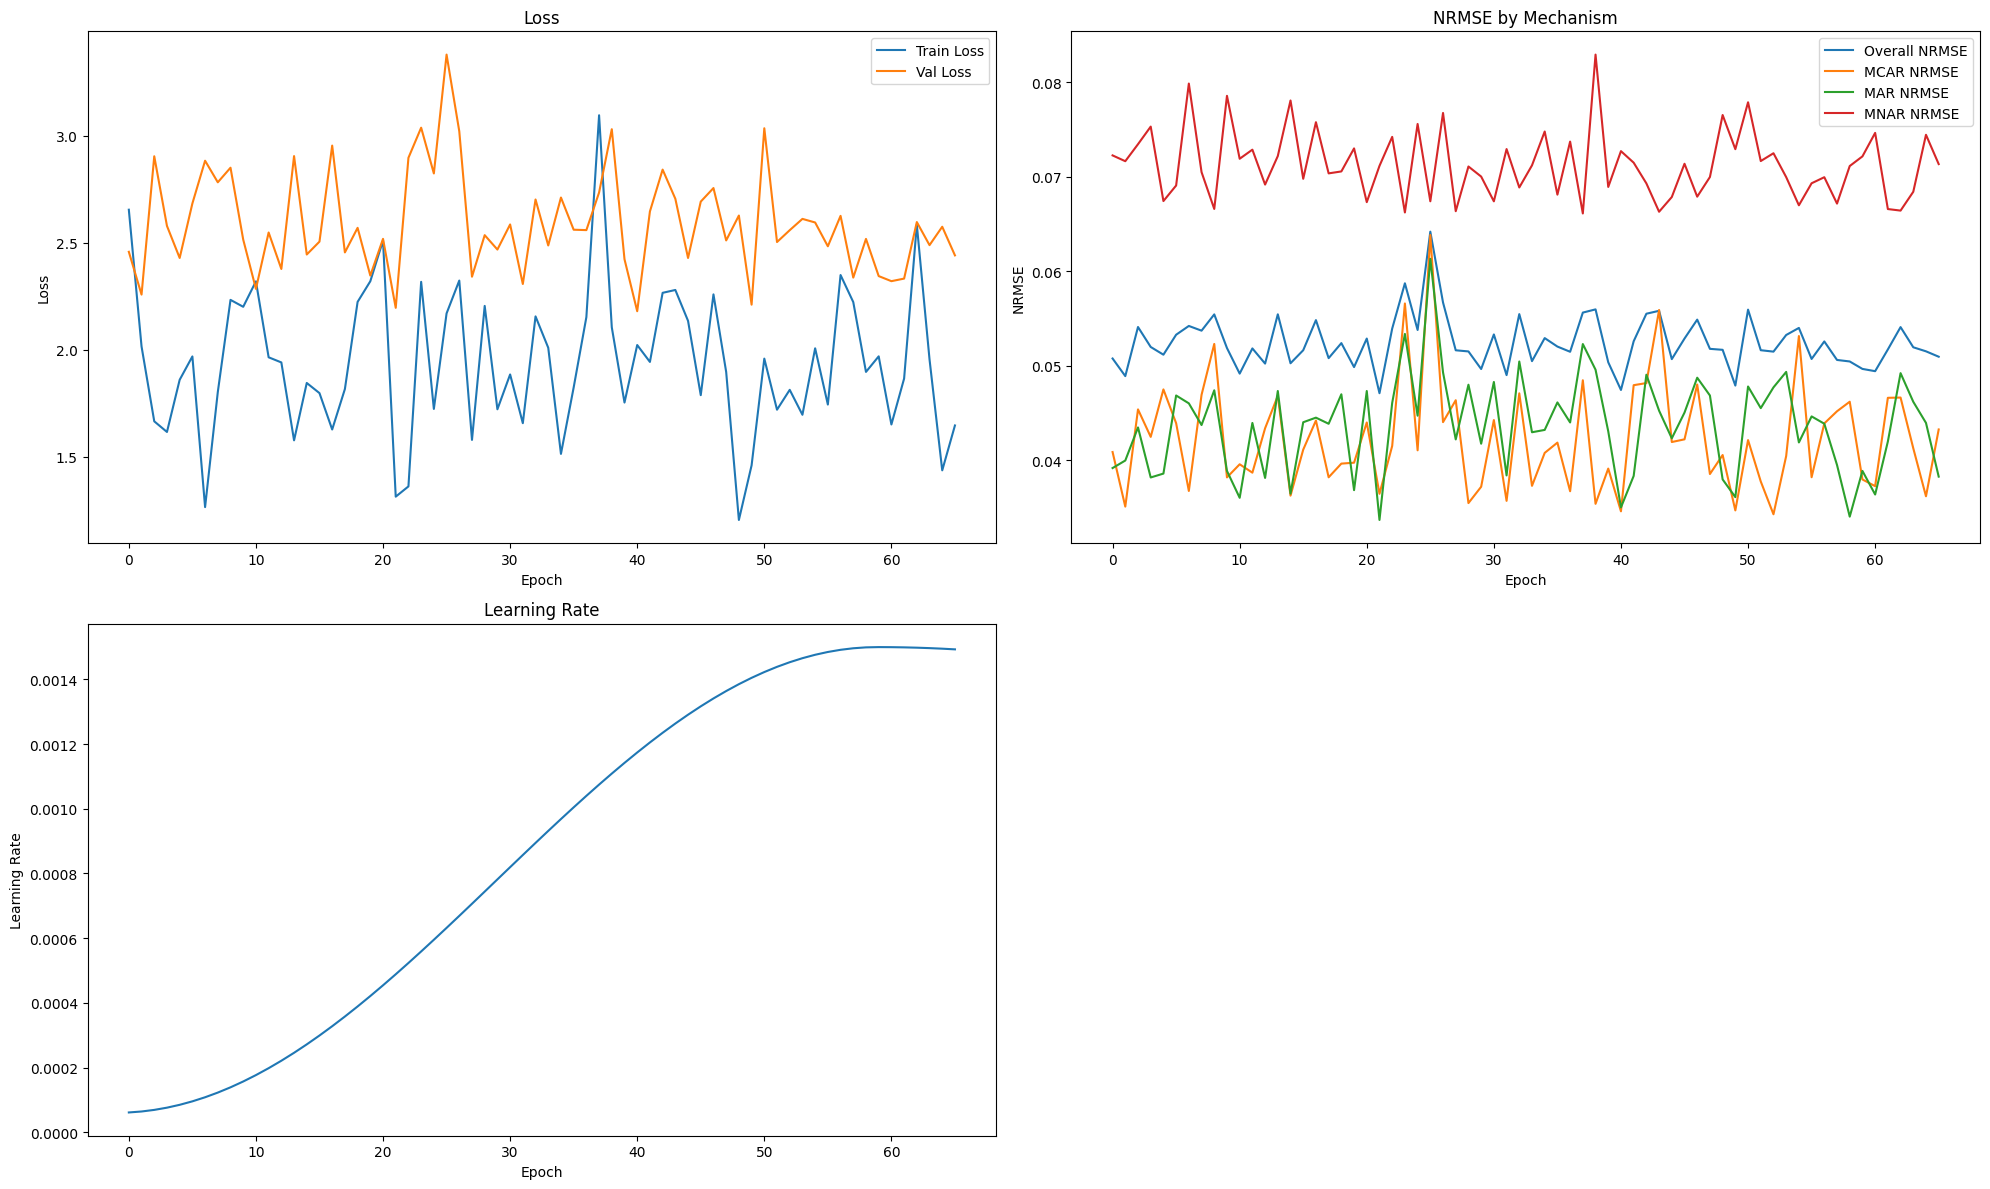


=== Training Specialized MNAR Model ===
Starting specialized MNAR model training...

Epoch 1/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=1.39]


Train Loss: 3.4819
Val Loss: 4.3952
Val MNAR NRMSE: 0.0682
New best validation loss: 4.3952

Epoch 2/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.98it/s, loss=4.18]


Train Loss: 2.7044
Val Loss: 4.1399
Val MNAR NRMSE: 0.0668
New best validation loss: 4.1399

Epoch 3/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=2.21]


Train Loss: 2.6663
Val Loss: 4.0948
Val MNAR NRMSE: 0.0660
New best validation loss: 4.0948

Epoch 4/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=2.43]


Train Loss: 2.6554
Val Loss: 4.1475
Val MNAR NRMSE: 0.0663
No improvement for 1 epochs

Epoch 5/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=6.96]


Train Loss: 2.5255
Val Loss: 4.1372
Val MNAR NRMSE: 0.0661
No improvement for 2 epochs

Epoch 6/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=1.44]


Train Loss: 2.4896
Val Loss: 4.2326
Val MNAR NRMSE: 0.0676
No improvement for 3 epochs

Epoch 7/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=2]   


Train Loss: 2.7683
Val Loss: 4.3898
Val MNAR NRMSE: 0.0698
No improvement for 4 epochs

Epoch 8/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.62it/s, loss=3.51]


Train Loss: 2.5638
Val Loss: 4.0129
Val MNAR NRMSE: 0.0648
New best validation loss: 4.0129

Epoch 9/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=2.89]


Train Loss: 2.4695
Val Loss: 3.8893
Val MNAR NRMSE: 0.0640
New best validation loss: 3.8893

Epoch 10/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.99it/s, loss=3.78]


Train Loss: 2.2911
Val Loss: 4.0026
Val MNAR NRMSE: 0.0669
No improvement for 1 epochs

Epoch 11/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=2.09]


Train Loss: 2.7721
Val Loss: 3.8649
Val MNAR NRMSE: 0.0633
New best validation loss: 3.8649

Epoch 12/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=1.13]


Train Loss: 2.5137
Val Loss: 3.6872
Val MNAR NRMSE: 0.0614
New best validation loss: 3.6872

Epoch 13/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=1.38]


Train Loss: 2.7602
Val Loss: 3.3131
Val MNAR NRMSE: 0.0576
New best validation loss: 3.3131

Epoch 14/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=1.95]


Train Loss: 2.1629
Val Loss: 3.3059
Val MNAR NRMSE: 0.0571
New best validation loss: 3.3059

Epoch 15/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=1.26]


Train Loss: 1.9418
Val Loss: 3.0581
Val MNAR NRMSE: 0.0540
New best validation loss: 3.0581

Epoch 16/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=1.14]


Train Loss: 1.6057
Val Loss: 2.7230
Val MNAR NRMSE: 0.0506
New best validation loss: 2.7230

Epoch 17/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.70it/s, loss=2.35] 


Train Loss: 1.4732
Val Loss: 2.6223
Val MNAR NRMSE: 0.0479
New best validation loss: 2.6223

Epoch 18/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.98it/s, loss=1.12]


Train Loss: 1.4258
Val Loss: 2.5008
Val MNAR NRMSE: 0.0455
New best validation loss: 2.5008

Epoch 19/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=1.09]


Train Loss: 1.3833
Val Loss: 2.3698
Val MNAR NRMSE: 0.0430
New best validation loss: 2.3698

Epoch 20/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.85it/s, loss=0.743]


Train Loss: 1.2658
Val Loss: 2.1038
Val MNAR NRMSE: 0.0388
New best validation loss: 2.1038

Epoch 21/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=0.518]


Train Loss: 1.3876
Val Loss: 2.2878
Val MNAR NRMSE: 0.0418
No improvement for 1 epochs

Epoch 22/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.99it/s, loss=1.74]


Train Loss: 1.2478
Val Loss: 2.1136
Val MNAR NRMSE: 0.0401
No improvement for 2 epochs

Epoch 23/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s, loss=2.27]


Train Loss: 1.3690
Val Loss: 2.2156
Val MNAR NRMSE: 0.0414
No improvement for 3 epochs

Epoch 24/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=0.766]


Train Loss: 1.1776
Val Loss: 2.3257
Val MNAR NRMSE: 0.0423
No improvement for 4 epochs

Epoch 25/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.96it/s, loss=1.21]


Train Loss: 1.3520
Val Loss: 2.1219
Val MNAR NRMSE: 0.0399
No improvement for 5 epochs

Epoch 26/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.99it/s, loss=0.566]


Train Loss: 1.0739
Val Loss: 2.1390
Val MNAR NRMSE: 0.0395
No improvement for 6 epochs

Epoch 27/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=1.31]


Train Loss: 1.1592
Val Loss: 2.2040
Val MNAR NRMSE: 0.0410
No improvement for 7 epochs

Epoch 28/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.03it/s, loss=1.34]


Train Loss: 1.1556
Val Loss: 2.4107
Val MNAR NRMSE: 0.0438
No improvement for 8 epochs

Epoch 29/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.96it/s, loss=0.812]


Train Loss: 1.2377
Val Loss: 2.2523
Val MNAR NRMSE: 0.0406
No improvement for 9 epochs

Epoch 30/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=1]    


Train Loss: 1.1839
Val Loss: 2.2924
Val MNAR NRMSE: 0.0423
No improvement for 10 epochs

Epoch 31/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.02it/s, loss=1.38] 


Train Loss: 1.1445
Val Loss: 2.2830
Val MNAR NRMSE: 0.0426
No improvement for 11 epochs

Epoch 32/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=0.581]


Train Loss: 1.3795
Val Loss: 2.4731
Val MNAR NRMSE: 0.0438
No improvement for 12 epochs

Epoch 33/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.01it/s, loss=1.47]


Train Loss: 1.1621
Val Loss: 2.2464
Val MNAR NRMSE: 0.0416
No improvement for 13 epochs

Epoch 34/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s, loss=0.687]


Train Loss: 1.3746
Val Loss: 2.1707
Val MNAR NRMSE: 0.0415
No improvement for 14 epochs

Epoch 35/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=0.361]


Train Loss: 1.2216
Val Loss: 2.5426
Val MNAR NRMSE: 0.0459
No improvement for 15 epochs

Epoch 36/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.03it/s, loss=0.73]


Train Loss: 1.1853
Val Loss: 2.3005
Val MNAR NRMSE: 0.0427
No improvement for 16 epochs

Epoch 37/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=1.82]


Train Loss: 1.2430
Val Loss: 2.5786
Val MNAR NRMSE: 0.0456
No improvement for 17 epochs

Epoch 38/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=1.16]


Train Loss: 1.0803
Val Loss: 2.3242
Val MNAR NRMSE: 0.0429
No improvement for 18 epochs

Epoch 39/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=0.724]


Train Loss: 1.1538
Val Loss: 2.2082
Val MNAR NRMSE: 0.0411
No improvement for 19 epochs

Epoch 40/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=0.589]


Train Loss: 1.0148
Val Loss: 2.0902
Val MNAR NRMSE: 0.0400
New best validation loss: 2.0902

Epoch 41/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=0.787]


Train Loss: 1.1645
Val Loss: 2.2331
Val MNAR NRMSE: 0.0415
No improvement for 1 epochs

Epoch 42/150


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=0.679]


Train Loss: 1.0868
Val Loss: 2.2538
Val MNAR NRMSE: 0.0416
No improvement for 2 epochs

Epoch 43/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, loss=1.37]


Train Loss: 1.1988
Val Loss: 2.6484
Val MNAR NRMSE: 0.0477
No improvement for 3 epochs

Epoch 44/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=0.517]


Train Loss: 1.0826
Val Loss: 2.3245
Val MNAR NRMSE: 0.0424
No improvement for 4 epochs

Epoch 45/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=1.13]


Train Loss: 1.1266
Val Loss: 2.2545
Val MNAR NRMSE: 0.0394
No improvement for 5 epochs

Epoch 46/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.85it/s, loss=2.59]


Train Loss: 1.0129
Val Loss: 2.3117
Val MNAR NRMSE: 0.0426
No improvement for 6 epochs

Epoch 47/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=0.427]


Train Loss: 1.1292
Val Loss: 2.3479
Val MNAR NRMSE: 0.0425
No improvement for 7 epochs

Epoch 48/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=0.866]


Train Loss: 1.0001
Val Loss: 2.3257
Val MNAR NRMSE: 0.0436
No improvement for 8 epochs

Epoch 49/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.98it/s, loss=0.514]


Train Loss: 0.9761
Val Loss: 2.2060
Val MNAR NRMSE: 0.0412
No improvement for 9 epochs

Epoch 50/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.96it/s, loss=0.913]


Train Loss: 1.0378
Val Loss: 2.2020
Val MNAR NRMSE: 0.0416
No improvement for 10 epochs

Epoch 51/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.65it/s, loss=1.09]


Train Loss: 1.2045
Val Loss: 2.2931
Val MNAR NRMSE: 0.0427
No improvement for 11 epochs

Epoch 52/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s, loss=1.61] 


Train Loss: 1.1270
Val Loss: 2.2386
Val MNAR NRMSE: 0.0424
No improvement for 12 epochs

Epoch 53/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=0.719]


Train Loss: 1.0894
Val Loss: 2.3366
Val MNAR NRMSE: 0.0426
No improvement for 13 epochs

Epoch 54/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=0.941]


Train Loss: 1.1390
Val Loss: 2.2392
Val MNAR NRMSE: 0.0424
No improvement for 14 epochs

Epoch 55/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.70it/s, loss=1.17]


Train Loss: 1.0640
Val Loss: 2.2800
Val MNAR NRMSE: 0.0426
No improvement for 15 epochs

Epoch 56/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.75it/s, loss=2.2] 


Train Loss: 1.3045
Val Loss: 2.2950
Val MNAR NRMSE: 0.0419
No improvement for 16 epochs

Epoch 57/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.70it/s, loss=1.53] 


Train Loss: 1.1289
Val Loss: 2.2361
Val MNAR NRMSE: 0.0412
No improvement for 17 epochs

Epoch 58/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=1.52] 


Train Loss: 1.0572
Val Loss: 2.4472
Val MNAR NRMSE: 0.0415
No improvement for 18 epochs

Epoch 59/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.69it/s, loss=1.7]  


Train Loss: 0.9301
Val Loss: 2.2538
Val MNAR NRMSE: 0.0401
No improvement for 19 epochs

Epoch 60/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=0.649]


Train Loss: 1.0172
Val Loss: 2.4831
Val MNAR NRMSE: 0.0435
No improvement for 20 epochs

Epoch 61/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s, loss=0.869]


Train Loss: 1.0216
Val Loss: 2.2601
Val MNAR NRMSE: 0.0409
No improvement for 21 epochs

Epoch 62/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=1.42]


Train Loss: 1.1191
Val Loss: 2.1017
Val MNAR NRMSE: 0.0398
No improvement for 22 epochs

Epoch 63/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=1.09]


Train Loss: 1.0159
Val Loss: 2.2085
Val MNAR NRMSE: 0.0400
No improvement for 23 epochs

Epoch 64/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s, loss=0.328]


Train Loss: 0.9761
Val Loss: 2.2413
Val MNAR NRMSE: 0.0407
No improvement for 24 epochs

Epoch 65/150


Training: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, loss=0.963]


Train Loss: 1.0116
Val Loss: 2.1429
Val MNAR NRMSE: 0.0412
No improvement for 25 epochs
Early stopping after 65 epochs
MNAR Specialized Model - Test MNAR NRMSE: 0.0602

=== Evaluating on Test Set ===
Test metrics:
  Overall NRMSE: 0.0651
  MCAR NRMSE: 0.0560
  MAR NRMSE: 0.0584
  MNAR NRMSE: 0.0810

=== Creating Hybrid Predictor ===
Testing hybrid approach on test set...
Hybrid approach test results:
  Overall NRMSE: 0.1715
  MCAR NRMSE: 0.0560
  MAR NRMSE: 0.0598
  MNAR NRMSE: 0.0558

=== Saving Models ===
Training complete! All models and results saved in: models\2025-03-31_16-00-15_model-ensemble+5Fold


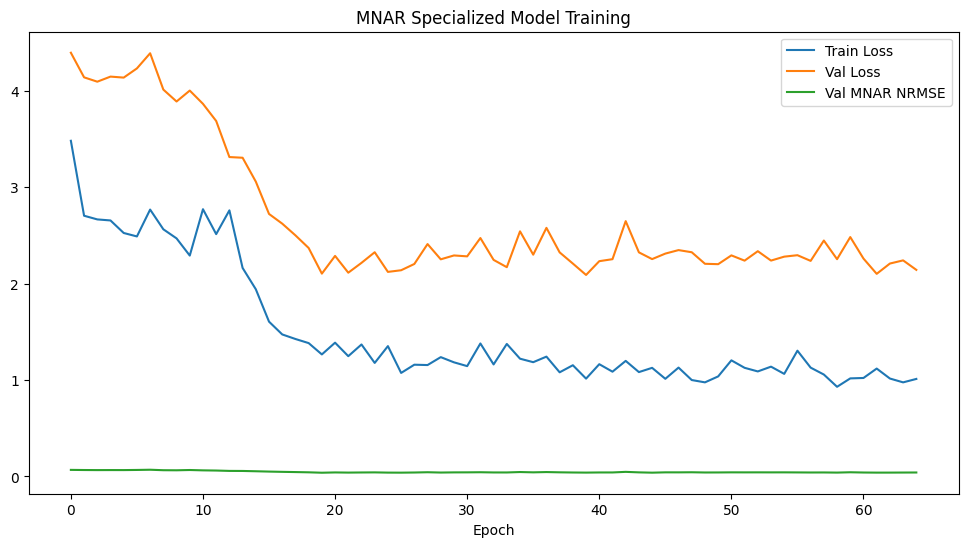

In [22]:
# Main execution code
if __name__ == "__main__":
    # Configuration
    config = {
        # Data parameters
        "data_path": "./data/physionet_39_features_only.csv",
        "test_size": 0.2,
        "val_size": 0.1,
        
        # Model parameters
        "d_model": 384,              # Increased from 256
        "num_heads": 12,             # Increased from 8
        "num_layers": 6,             # Increased from 5
        "dim_feedforward": 1536,     # Increased from 1024
        "dropout": 0.15,             # Reduced from 0.2 for better generalization
        "activation": "gelu",
        
        # Training parameters
        "batch_size": 128,           # Increased from 64
        "learning_rate": 0.0015,     # Slightly higher for faster initial training
        "weight_decay": 0.005,       # Reduced from 0.01
        "num_epochs": 200,           # Doubled from 100
        "patience": 25,              # Increased from 15
        "missing_fraction": 0.3,
        
        "warmup_steps_pct": 0.2,     # Shorter warmup phase
        "min_lr_factor": 5000.0,     # Slower final decay
        
        # Save parameters
        "save_dir": "models"
    }
    
    # Create directories with timestamp
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(config["save_dir"], f"{current_time}_model-ensemble+5Fold")
    os.makedirs(save_dir, exist_ok=True)
    
    # Create experiment log file
    experiment_log = os.path.join(save_dir, "experiment_log.txt")
    with open(experiment_log, "w") as f:
        f.write(f"Experiment started at: {current_time}\n")
        f.write("Configuration:\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
    
    # Load and prepare data
    train_data, val_data, test_data, scaler, column_indices = load_and_prepare_data(
        config["data_path"],
        config["test_size"],
        config["val_size"]
    )
    
    # Add flag to control whether to run k-fold validation
    RUN_KFOLD = True
    
    if RUN_KFOLD:
        print("\n=== Running K-Fold Cross-Validation ===")
        # Combine train and validation data for k-fold
        combined_data = torch.cat([train_data, val_data], dim=0)
        
        # Set a smaller number of epochs for k-fold to save time
        kfold_config = config.copy()
        kfold_config["num_epochs"] = 100  # Reduced epochs for k-fold
        
        # Run k-fold validation with single model
        print("\n---- K-Fold with Single Model ----")
        cv_metrics_single, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=5,
            model_type="single"
        )
        
        # Run k-fold validation with ensemble model
        print("\n---- K-Fold with Ensemble Model ----")
        cv_metrics_ensemble, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=3,  # Fewer folds for ensemble to save time
            model_type="ensemble"
        )
        
        # Save cross-validation results
        cv_results_path = os.path.join(save_dir, "cv_results.txt")
        with open(cv_results_path, "w") as f:
            f.write("Single Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_single['nrmse']:.4f} ± {cv_metrics_single['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_single['mcar_nrmse']:.4f} ± {cv_metrics_single['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_single['mar_nrmse']:.4f} ± {cv_metrics_single['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_single['mnar_nrmse']:.4f} ± {cv_metrics_single['mnar_nrmse_std']:.4f}\n\n")
            
            f.write("Ensemble Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_ensemble['nrmse']:.4f} ± {cv_metrics_ensemble['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_ensemble['mcar_nrmse']:.4f} ± {cv_metrics_ensemble['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_ensemble['mar_nrmse']:.4f} ± {cv_metrics_ensemble['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_ensemble['mnar_nrmse']:.4f} ± {cv_metrics_ensemble['mnar_nrmse_std']:.4f}\n")
    
    # Choose model type based on cross-validation results (if performed)
    if RUN_KFOLD and cv_metrics_ensemble['nrmse'] < cv_metrics_single['nrmse']:
        print("\nEnsemble model performed better in cross-validation. Using ensemble for final model.")
        final_model_type = "ensemble"
    else:
        print("\nUsing single model for final training.")
        final_model_type = "single"
    
    # Train final model on the entire training set
    print("\n=== Training Final Model ===")
    model, history = train_model(train_data, val_data, column_indices, config, model_type=final_model_type)
    
    # Plot training history
    plot_training_history(history, os.path.join(save_dir, "training_history.png"))
    
    # Create specialized MNAR model
    TRAIN_SPECIALIZED = True
    
    if TRAIN_SPECIALIZED:
        print("\n=== Training Specialized MNAR Model ===")
        mnar_config = config.copy()
        mnar_config["learning_rate"] = 0.001  # Slightly lower learning rate
        mnar_config["num_epochs"] = 150  # Fewer epochs
        
        mnar_model, mnar_history = train_mnar_specialized_model(
            train_data, val_data, column_indices, mnar_config
        )
        
        # Plot MNAR model training history
        plt.figure(figsize=(12, 6))
        plt.plot(mnar_history["train_loss"], label="Train Loss")
        plt.plot(mnar_history["val_loss"], label="Val Loss")
        plt.plot(mnar_history["val_mnar_nrmse"], label="Val MNAR NRMSE")
        plt.title("MNAR Specialized Model Training")
        plt.xlabel("Epoch")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "mnar_model_history.png"))
        
        # Evaluate MNAR model on test set
        test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
        mnar_test_metrics = validate(mnar_model, test_dataloader, config["missing_fraction"], ["MNAR"])
        
        print(f"MNAR Specialized Model - Test MNAR NRMSE: {mnar_test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Save MNAR model
        mnar_model_path = os.path.join(save_dir, "mnar_specialized_model.pth")
        torch.save({
            "model_state_dict": mnar_model.state_dict(),
            "config": mnar_config
        }, mnar_model_path)
    
    # Evaluate on test set
    print("\n=== Evaluating on Test Set ===")
    test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
    test_metrics = validate(model, test_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
    
    print(f"Test metrics:")
    print(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}")
    print(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
    print(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}")
    print(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Create hybrid predictor for MNAR if the specialized model exists
    if TRAIN_SPECIALIZED:
        print("\n=== Creating Hybrid Predictor ===")
        # Function to combine predictions for hybrid approach
        def predict_hybrid(data, mask, general_model, mnar_model, column_indices):
            general_model.eval()
            mnar_model.eval()
            
            with torch.no_grad():
                # Get predictions from both models
                general_preds = general_model(data, column_indices, mask)
                mnar_preds = mnar_model(data, column_indices, mask)
                
                # Create a new mask that's zero for MCAR/MAR and one for MNAR
                # For simplicity, we're randomly assigning mechanisms per sample
                mnar_indicator = torch.zeros_like(mask)
                for i in range(mask.size(0)):
                    # Assign this sample to MNAR with 1/3 probability
                    if random.random() < 0.333:
                        mnar_indicator[i] = 1
                
                # Combine predictions: use MNAR model for MNAR patterns and general model for others
                combined_preds = (1 - mnar_indicator) * general_preds + mnar_indicator * mnar_preds
                
                return combined_preds
        
        # Test the hybrid approach
        print("Testing hybrid approach on test set...")
        
        # First, create a mask for the whole test set
        test_hybrid_metrics = {"mcar": 0, "mar": 0, "mnar": 0, "overall": 0}
        test_count = 0
        
        with torch.no_grad():
            for batch in test_dataloader:
                x = batch[0].to(device)
                
                for mechanism in ["MCAR", "MAR", "MNAR"]:
                    # Create a mask based on the mechanism
                    mask = create_missing_mask(x, config["missing_fraction"], mechanism)
                    
                    # Create input with missing values
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Get column indices
                    col_indices = torch.arange(x.shape[1], device=device)
                    
                    # Predict using the hybrid approach
                    if mechanism == "MNAR":
                        # Use MNAR specialized model
                        predictions = mnar_model(x_masked, col_indices, mask)
                    else:
                        # Use general model
                        predictions = model(x_masked, col_indices, mask)
                    
                    # Calculate NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    test_hybrid_metrics[mechanism.lower()] += nrmse
                    test_hybrid_metrics["overall"] += nrmse
                    test_count += 1
        
        # Calculate average
        for key in test_hybrid_metrics:
            test_hybrid_metrics[key] /= (test_count / 3)  # Divide by number of mechanisms
        
        print(f"Hybrid approach test results:")
        print(f"  Overall NRMSE: {test_hybrid_metrics['overall']:.4f}")
        print(f"  MCAR NRMSE: {test_hybrid_metrics['mcar']:.4f}")
        print(f"  MAR NRMSE: {test_hybrid_metrics['mar']:.4f}")
        print(f"  MNAR NRMSE: {test_hybrid_metrics['mnar']:.4f}")
    
    # Save test results
    test_results_path = os.path.join(save_dir, "test_results.txt")
    with open(test_results_path, "w") as f:
        f.write("Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        if TRAIN_SPECIALIZED:
            f.write("\nHybrid Model Results:\n")
            f.write(f"  Overall NRMSE: {test_hybrid_metrics['overall']:.4f}\n")
            f.write(f"  MCAR NRMSE: {test_hybrid_metrics['mcar']:.4f}\n")
            f.write(f"  MAR NRMSE: {test_hybrid_metrics['mar']:.4f}\n")
            f.write(f"  MNAR NRMSE: {test_hybrid_metrics['mnar']:.4f}\n")
    
    # Save models
    print(f"\n=== Saving Models ===")
    
    # Save final model
    model_save_path = os.path.join(save_dir, "final_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "model_type": final_model_type
    }, model_save_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    # Update experiment log
    with open(experiment_log, "a") as f:
        f.write("\nFinal Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        if TRAIN_SPECIALIZED:
            f.write("\nHybrid Model Results:\n")
            f.write(f"  Overall NRMSE: {test_hybrid_metrics['overall']:.4f}\n")
            f.write(f"  MCAR NRMSE: {test_hybrid_metrics['mcar']:.4f}\n")
            f.write(f"  MAR NRMSE: {test_hybrid_metrics['mar']:.4f}\n")
            f.write(f"  MNAR NRMSE: {test_hybrid_metrics['mnar']:.4f}\n")
        
        f.write(f"\nExperiment completed at: {datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

    print(f"Training complete! All models and results saved in: {save_dir}")



## Model testing

In [23]:
def evaluate_imputation_performance(model, test_data, column_indices, missing_percentages=[0.1, 0.2, 0.3, 0.4, 0.5], 
                                    mechanisms=["MCAR", "MAR", "MNAR"]):
    """
    Evaluate the model's imputation performance across different missing percentages and mechanisms.
    
    Args:
        model (nn.Module): Trained model
        test_data (torch.Tensor): Test data tensor
        column_indices (torch.Tensor): Column indices
        missing_percentages (list): List of missing data percentages to evaluate
        mechanisms (list): List of missing data mechanisms to evaluate
        
    Returns:
        pd.DataFrame: DataFrame with NRMSE results for each mechanism and percentage
    """
    model.eval()
    results = {}
    
    with torch.no_grad():
        for mechanism in mechanisms:
            mechanism_results = []
            
            for missing_pct in missing_percentages:
                batch_size = 128
                total_nrmse = 0
                num_batches = 0
                
                # Create DataLoader for test data
                test_dataloader = DataLoader(TensorDataset(test_data), batch_size=batch_size)
                
                for batch in tqdm(test_dataloader, desc=f"Evaluating {mechanism} at {missing_pct*100}%"):
                    x = batch[0].to(device)
                    
                    # Create a mask for missing values
                    mask = create_missing_mask(x, missing_pct, mechanism)
                    
                    # Create input with missing values set to 0
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Forward pass
                    predictions = model(x_masked, column_indices, mask)
                    
                    # Compute NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    total_nrmse += nrmse
                    num_batches += 1
                
                avg_nrmse = total_nrmse / num_batches
                mechanism_results.append(avg_nrmse)
                print(f"{mechanism} at {missing_pct*100}% missing: NRMSE = {avg_nrmse:.4f}")
            
            results[mechanism] = mechanism_results
    
    # Create a DataFrame for visualization
    results_df = pd.DataFrame(results, index=[f"{int(pct*100)}%" for pct in missing_percentages])
    results_df.index.name = "Missing Percentage"
    
    return results_df

In [24]:
def visualize_imputation_performance(results_df, save_path=None):
    """
    Create visualizations for imputation performance.
    
    Args:
        results_df (pd.DataFrame): DataFrame with NRMSE results
        save_path (str, optional): Path to save the figures
    """
    # 1. Create a heatmap visualization
    plt.figure(figsize=(10, 6))
    
    # Create a heatmap with custom colormap (lower values = better = greener)
    sns.heatmap(results_df, annot=True, cmap="RdYlGn_r", fmt=".4f", 
                linewidths=.5, cbar_kws={'label': 'NRMSE (lower is better)'})
    
    plt.title("Imputation Performance (NRMSE) by Missing Mechanism and Percentage")
    plt.tight_layout()
    
    if save_path:
        heatmap_path = save_path.replace(".png", "_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"Heatmap saved to {heatmap_path}")
    
    plt.show()
    
    # 2. Create a line plot
    plt.figure(figsize=(12, 6))
    
    # Convert index to numeric for plotting
    results_df_plot = results_df.copy()
    results_df_plot.index = [int(idx.replace("%", "")) for idx in results_df_plot.index]
    
    # Plot lines for each mechanism
    for column in results_df_plot.columns:
        plt.plot(results_df_plot.index, results_df_plot[column], marker='o', linewidth=2, label=column)
    
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance Across Missing Percentages")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(results_df_plot.index)
    
    if save_path:
        line_path = save_path.replace(".png", "_lineplot.png")
        plt.savefig(line_path)
        print(f"Line plot saved to {line_path}")
    
    plt.show()
    
    # 3. Create a bar chart comparison
    plt.figure(figsize=(12, 6))
    
    # Plot grouped bars
    bar_width = 0.25
    r = np.arange(len(results_df_plot.index))
    
    # Plot bars for each mechanism
    for i, column in enumerate(results_df_plot.columns):
        plt.bar(r + i*bar_width, results_df_plot[column], width=bar_width, label=column)
    
    # Add labels and legend
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance by Missing Mechanism and Percentage")
    plt.xticks(r + bar_width, results_df_plot.index)
    plt.legend()
    
    if save_path:
        bar_path = save_path.replace(".png", "_barchart.png")
        plt.savefig(bar_path)
        print(f"Bar chart saved to {bar_path}")
    
    plt.show()
    
    # 4. Create a table visualization
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    ax.axis('tight')
    
    # Create a table with colored cells based on values
    # First, normalize the data for coloring
    norm_data = results_df.copy()
    for col in norm_data.columns:
        max_val = norm_data[col].max()
        min_val = norm_data[col].min()
        if max_val > min_val:
            norm_data[col] = (norm_data[col] - min_val) / (max_val - min_val)
        else:
            norm_data[col] = 0
    
    # Create a table with cell colors
    cell_colors = plt.cm.RdYlGn_r(norm_data.values)
    table = ax.table(cellText=results_df.values.round(4), 
                    rowLabels=results_df.index,
                    colLabels=results_df.columns,
                    cellColours=cell_colors,
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title("NRMSE Values by Missing Mechanism and Percentage", y=0.8)
    
    if save_path:
        table_path = save_path.replace(".png", "_table.png")
        plt.savefig(table_path, bbox_inches='tight')
        print(f"Table visualization saved to {table_path}")
    
    plt.show()
    
    return results_df


=== Evaluating Imputation Performance Across Missing Percentages ===


Evaluating MCAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 28.56it/s]


MCAR at 10.0% missing: NRMSE = 0.0496


Evaluating MCAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 35.30it/s]


MCAR at 20.0% missing: NRMSE = 0.0503


Evaluating MCAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 36.81it/s]


MCAR at 30.0% missing: NRMSE = 0.0506


Evaluating MCAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 36.30it/s]


MCAR at 40.0% missing: NRMSE = 0.0532


Evaluating MCAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 36.75it/s]


MCAR at 50.0% missing: NRMSE = 0.0503


Evaluating MAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 24.08it/s]


MAR at 10.0% missing: NRMSE = 0.0622


Evaluating MAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 24.30it/s]


MAR at 20.0% missing: NRMSE = 0.0552


Evaluating MAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 24.24it/s]


MAR at 30.0% missing: NRMSE = 0.0573


Evaluating MAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 24.03it/s]


MAR at 40.0% missing: NRMSE = 0.0550


Evaluating MAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 23.62it/s]


MAR at 50.0% missing: NRMSE = 0.0559


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 24.18it/s]


MNAR at 10.0% missing: NRMSE = 0.0812


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 24.07it/s]


MNAR at 20.0% missing: NRMSE = 0.0815


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 24.14it/s]


MNAR at 30.0% missing: NRMSE = 0.0799


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 22.50it/s]


MNAR at 40.0% missing: NRMSE = 0.0737


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 21.71it/s]


MNAR at 50.0% missing: NRMSE = 0.0672
Raw imputation results saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\imputation_performance\imputation_results.csv
Heatmap saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\imputation_performance\imputation_performance_heatmap.png


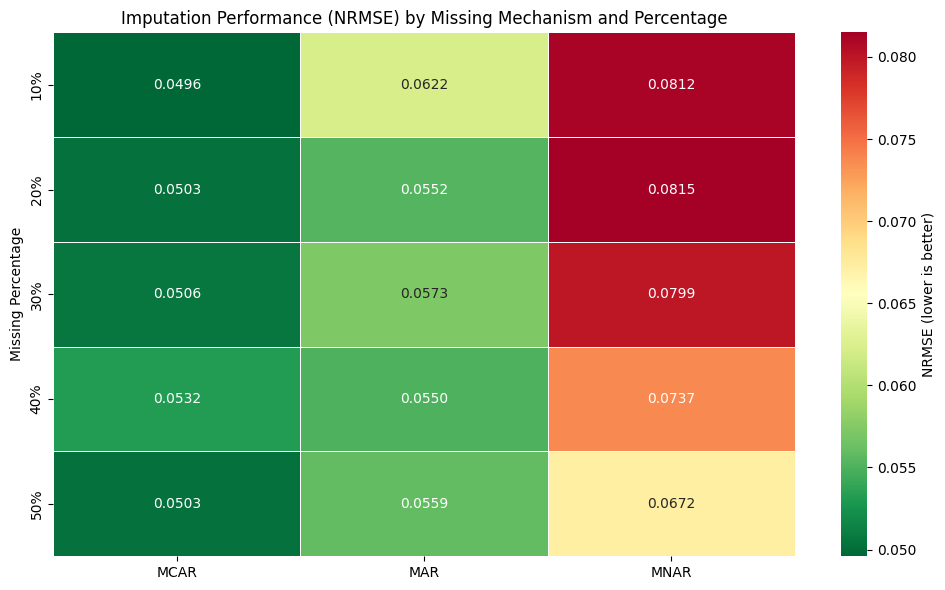

Line plot saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\imputation_performance\imputation_performance_lineplot.png


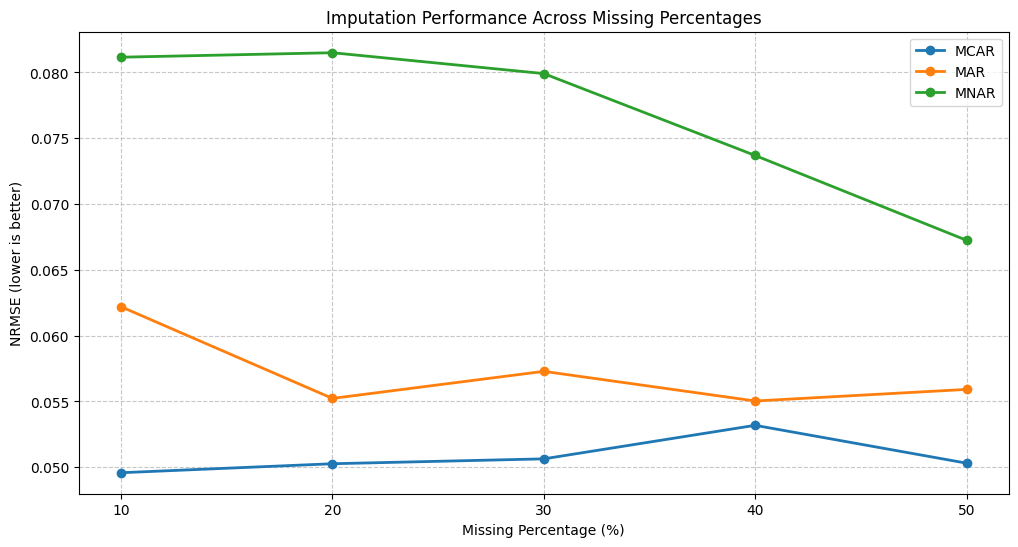

Bar chart saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\imputation_performance\imputation_performance_barchart.png


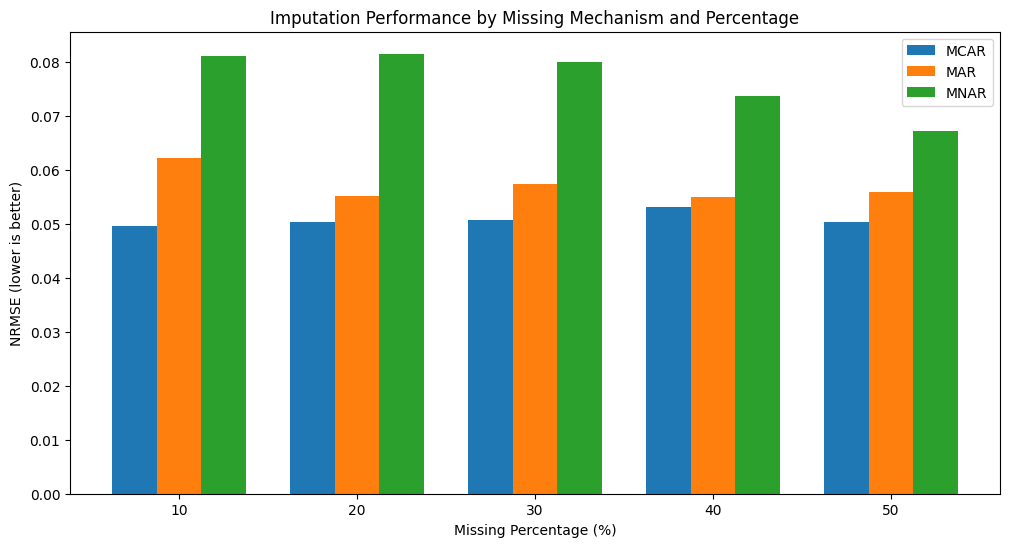

Table visualization saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\imputation_performance\imputation_performance_table.png


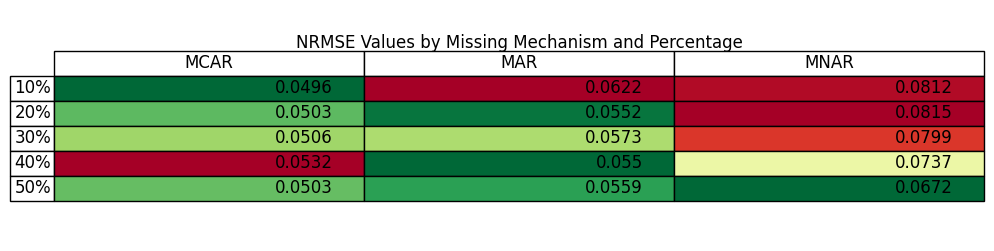


=== Evaluating MNAR Specialized Model Imputation Performance ===


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 23.94it/s]


MNAR at 10.0% missing: NRMSE = 0.0513


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 21.17it/s]


MNAR at 20.0% missing: NRMSE = 0.0588


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 24.71it/s]


MNAR at 30.0% missing: NRMSE = 0.0575


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 22.01it/s]


MNAR at 40.0% missing: NRMSE = 0.0640


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 24.67it/s]


MNAR at 50.0% missing: NRMSE = 0.0748
Raw MNAR specialized results saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\imputation_performance\mnar_specialized_results.csv


<Figure size 1000x600 with 0 Axes>

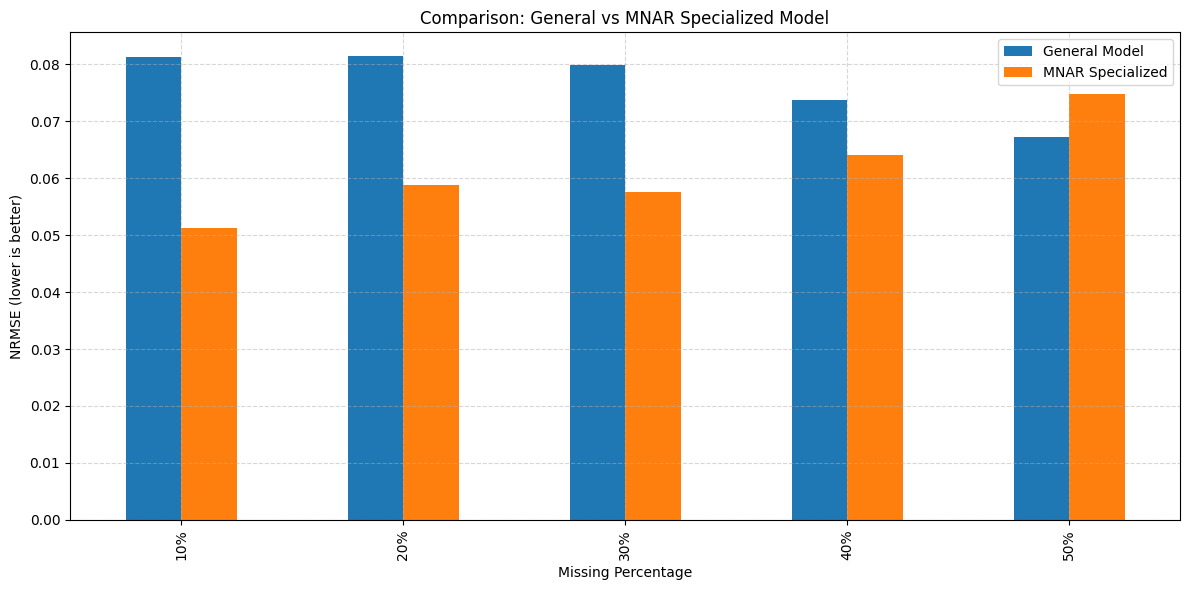


Imputation performance evaluation complete!


In [25]:
if __name__ == "__main__":
    # Create a section for imputation performance evaluation
    print("\n=== Evaluating Imputation Performance Across Missing Percentages ===")
    
    # Define the missing percentages to evaluate
    missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Create a directory for imputation performance visualizations
    imputation_dir = os.path.join(save_dir, "imputation_performance")
    os.makedirs(imputation_dir, exist_ok=True)
    
    # Evaluate imputation performance
    results_df = evaluate_imputation_performance(
        model,                    # Use the final trained model
        test_data,                # Test data
        column_indices,           # Column indices
        missing_percentages,      # Missing percentages
        mechanisms                # Missing mechanisms
    )
    
    # Save the raw results to CSV
    results_csv_path = os.path.join(imputation_dir, "imputation_results.csv")
    results_df.to_csv(results_csv_path)
    print(f"Raw imputation results saved to {results_csv_path}")
    
    # Create and save visualizations
    visualize_imputation_performance(
        results_df,
        save_path=os.path.join(imputation_dir, "imputation_performance.png")
    )
    
    # If specialized MNAR model exists, evaluate it too
    if TRAIN_SPECIALIZED:
        print("\n=== Evaluating MNAR Specialized Model Imputation Performance ===")
        
        # Only evaluate the MNAR mechanism for the specialized model
        mnar_results_df = evaluate_imputation_performance(
            mnar_model,               # The specialized MNAR model
            test_data,                # Test data
            column_indices,           # Column indices
            missing_percentages,      # Missing percentages
            ["MNAR"]                  # Only MNAR mechanism
        )
        
        # Save the raw results to CSV
        mnar_results_csv_path = os.path.join(imputation_dir, "mnar_specialized_results.csv")
        mnar_results_df.to_csv(mnar_results_csv_path)
        print(f"Raw MNAR specialized results saved to {mnar_results_csv_path}")
        
        # Compare general vs specialized model for MNAR
        comparison_df = pd.DataFrame({
            "General Model": results_df["MNAR"],
            "MNAR Specialized": mnar_results_df["MNAR"]
        })
        
        # Create comparison visualizations
        plt.figure(figsize=(10, 6))
        comparison_df.plot(kind='bar', figsize=(12, 6))
        plt.title("Comparison: General vs MNAR Specialized Model")
        plt.xlabel("Missing Percentage")
        plt.ylabel("NRMSE (lower is better)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(imputation_dir, "mnar_model_comparison.png"))
        plt.show()
        
    print("\nImputation performance evaluation complete!")

## Fresh Evaluation

In [26]:
def create_and_impute_datasets(original_data_path, save_dir, model, mnar_model=None, 
                               scaler=None, missing_percentages=[0.1, 0.2, 0.3, 0.4, 0.5], 
                               mechanisms=["MCAR", "MAR", "MNAR"]):
    """
    Create datasets with missing values from the original data,
    impute them using the trained model, and save both versions.
    
    Args:
        original_data_path (str): Path to the original CSV file
        save_dir (str): Directory to save the datasets
        model (nn.Module): Trained imputation model
        mnar_model (nn.Module, optional): Specialized MNAR model
        scaler (StandardScaler): Fitted scaler for the data
        missing_percentages (list): List of missing data percentages
        mechanisms (list): List of missing data mechanisms
    """
    print(f"Loading original dataset from {original_data_path}...")
    
    # Load original dataset
    df_original = pd.read_csv(original_data_path, index_col=0)
    
    # Create directory for datasets if it doesn't exist
    datasets_dir = os.path.join(save_dir, "datasets")
    os.makedirs(datasets_dir, exist_ok=True)
    
    # Save the original dataset (for reference)
    original_save_path = os.path.join(datasets_dir, "original_dataset.csv")
    df_original.to_csv(original_save_path)
    print(f"Original dataset saved to {original_save_path}")
    
    # Convert to numpy for processing
    data_np = df_original.to_numpy()
    
    # Scale the data if scaler is provided
    if scaler is not None:
        data_np_scaled = scaler.transform(data_np)
    else:
        print("Warning: No scaler provided. Using raw data without scaling.")
        data_np_scaled = data_np
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data_np_scaled, dtype=torch.float32).to(device)
    
    # Create column indices for model
    column_indices = torch.arange(data_tensor.shape[1]).to(device)
    
    # Dictionary to store imputation metrics
    imputation_metrics = {
        mechanism: {str(int(pct*100)): {} for pct in missing_percentages}
        for mechanism in mechanisms
    }
    
    model.eval()
    if mnar_model is not None:
        mnar_model.eval()
    
    with torch.no_grad():
        for mechanism in mechanisms:
            for missing_pct in missing_percentages:
                print(f"\nCreating dataset with {mechanism} missing at {missing_pct*100}%...")
                
                # Create a mask for missing values
                mask = create_missing_mask(data_tensor, missing_pct, mechanism)
                
                # Create input with missing values set to 0 (for the model)
                data_masked = data_tensor.clone()
                data_masked[mask == 1] = 0
                
                # Apply the model for imputation
                if mechanism == "MNAR" and mnar_model is not None:
                    print(f"Using specialized MNAR model for imputation...")
                    predictions = mnar_model(data_masked, column_indices, mask)
                else:
                    predictions = model(data_masked, column_indices, mask)
                
                # Compute metrics for logging
                rmse = compute_rmse(predictions, data_tensor, mask)
                nrmse = compute_nrmse(predictions, data_tensor, mask)
                
                imputation_metrics[mechanism][str(int(missing_pct*100))]["rmse"] = rmse
                imputation_metrics[mechanism][str(int(missing_pct*100))]["nrmse"] = nrmse
                
                print(f"Imputation RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}")
                
                # Create masked dataset by introducing NaN values
                df_missing = df_original.copy()
                mask_np = mask.cpu().numpy().astype(bool)
                
                # Convert tensor-indexed mask to DataFrame-indexed mask
                for i, row in enumerate(mask_np):
                    for j, is_missing in enumerate(row):
                        if is_missing:
                            df_missing.iloc[i, j] = np.nan
                
                # Create imputed dataset
                # First convert predictions back to original scale
                imputed_np = predictions.cpu().numpy()
                if scaler is not None:
                    imputed_np = scaler.inverse_transform(imputed_np)
                
                # Create a copy of the original with missing values
                df_imputed = df_original.copy()
                
                # Replace only the masked values with their predictions
                for i, row in enumerate(mask_np):
                    for j, is_missing in enumerate(row):
                        if is_missing:
                            df_imputed.iloc[i, j] = imputed_np[i, j]
                
                # Save both datasets
                missing_filename = f"{mechanism}_{int(missing_pct*100)}pct_missing.csv"
                imputed_filename = f"{mechanism}_{int(missing_pct*100)}pct_imputed.csv"
                
                missing_path = os.path.join(datasets_dir, missing_filename)
                imputed_path = os.path.join(datasets_dir, imputed_filename)
                
                df_missing.to_csv(missing_path)
                df_imputed.to_csv(imputed_path)
                
                print(f"Dataset with missing values saved to {missing_path}")
                print(f"Imputed dataset saved to {imputed_path}")
    
    # Save imputation metrics
    metrics_path = os.path.join(datasets_dir, "imputation_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(imputation_metrics, f, indent=4)
    
    print(f"\nImputation metrics saved to {metrics_path}")
    
    # Create a summary table of NRMSE values and save as CSV
    summary_data = {
        f"{mech}_{pct}%": imputation_metrics[mech][str(int(float(pct)))]["nrmse"] 
        for mech in mechanisms
        for pct in [10, 20, 30, 40, 50]
    }
    
    summary_df = pd.DataFrame([summary_data])
    summary_path = os.path.join(datasets_dir, "imputation_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    
    print(f"Imputation summary saved to {summary_path}")
    
    return imputation_metrics



=== Creating and Imputing Datasets with Missing Values ===
Loading original dataset from ./data/physionet_39_features_only.csv...
Original dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\original_dataset.csv

Creating dataset with MCAR missing at 10.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03874679654836655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05286034569144249' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.069658279418945' has dtype incompatible with int64, please explicitly cast to a compatible dtyp

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_10pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_10pct_imputed.csv

Creating dataset with MCAR missing at 20.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.006936073303223' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3177054226398468' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.013844966888428' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_20pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_20pct_imputed.csv

Creating dataset with MCAR missing at 30.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.012877941131592' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038850195705890656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31731072068214417' has dtype incompatible with int64, please explicitly cast to a compatible dtyp

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_30pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_30pct_imputed.csv

Creating dataset with MCAR missing at 40.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.013222694396973' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03879539668560028' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04322933778166771' has dtype incompatible with int64, please explicitly cast to a compatible dtyp

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_40pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_40pct_imputed.csv

Creating dataset with MCAR missing at 50.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.013611793518066' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05288086086511612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03883710503578186' has dtype incompatible with int64, please explicitly cast to a compatible dtyp

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_50pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MCAR_50pct_imputed.csv

Creating dataset with MAR missing at 10.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.012819290161133' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13695643842220306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]


Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_10pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_10pct_imputed.csv

Creating dataset with MAR missing at 20.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.006752967834473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.012750148773193' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13659442961215973' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_20pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_20pct_imputed.csv

Creating dataset with MAR missing at 30.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.012819290161133' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.006747722625732' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13526858389377594' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_30pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_30pct_imputed.csv

Creating dataset with MAR missing at 40.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.006861686706543' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.012661457061768' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.536317765712738' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_40pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_40pct_imputed.csv

Creating dataset with MAR missing at 50.0%...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.006861686706543' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.012661457061768' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13526858389377594' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_50pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MAR_50pct_imputed.csv

Creating dataset with MNAR missing at 10.0%...
Using specialized MNAR model for imputation...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.928973197937012' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.831347465515137' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.9651553630828857' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_10pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_10pct_imputed.csv

Creating dataset with MNAR missing at 20.0%...
Using specialized MNAR model for imputation...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.96484112739563' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.929139137268066' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.831398963928223' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_20pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_20pct_imputed.csv

Creating dataset with MNAR missing at 30.0%...
Using specialized MNAR model for imputation...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.963345766067505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.9273786544799805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.828593254089355' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_30pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_30pct_imputed.csv

Creating dataset with MNAR missing at 40.0%...
Using specialized MNAR model for imputation...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.963345766067505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.9273786544799805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.828593254089355' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_40pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_40pct_imputed.csv

Creating dataset with MNAR missing at 50.0%...
Using specialized MNAR model for imputation...
Imputation RMSE: nan, NRMSE: nan


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.963345766067505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.9273786544799805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed.iloc[i, j] = imputed_np[i, j]
C:\Users\wh1sper\AppData\Local\Temp\ipykernel_19912\2479286710.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.828593254089355' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Dataset with missing values saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_50pct_missing.csv
Imputed dataset saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\MNAR_50pct_imputed.csv

Imputation metrics saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\imputation_metrics.json
Imputation summary saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\datasets\imputation_summary.csv
Summary plot saved to models\2025-03-31_16-00-15_model-ensemble+5Fold\dataset_experiment\dataset_imputation_summary.png


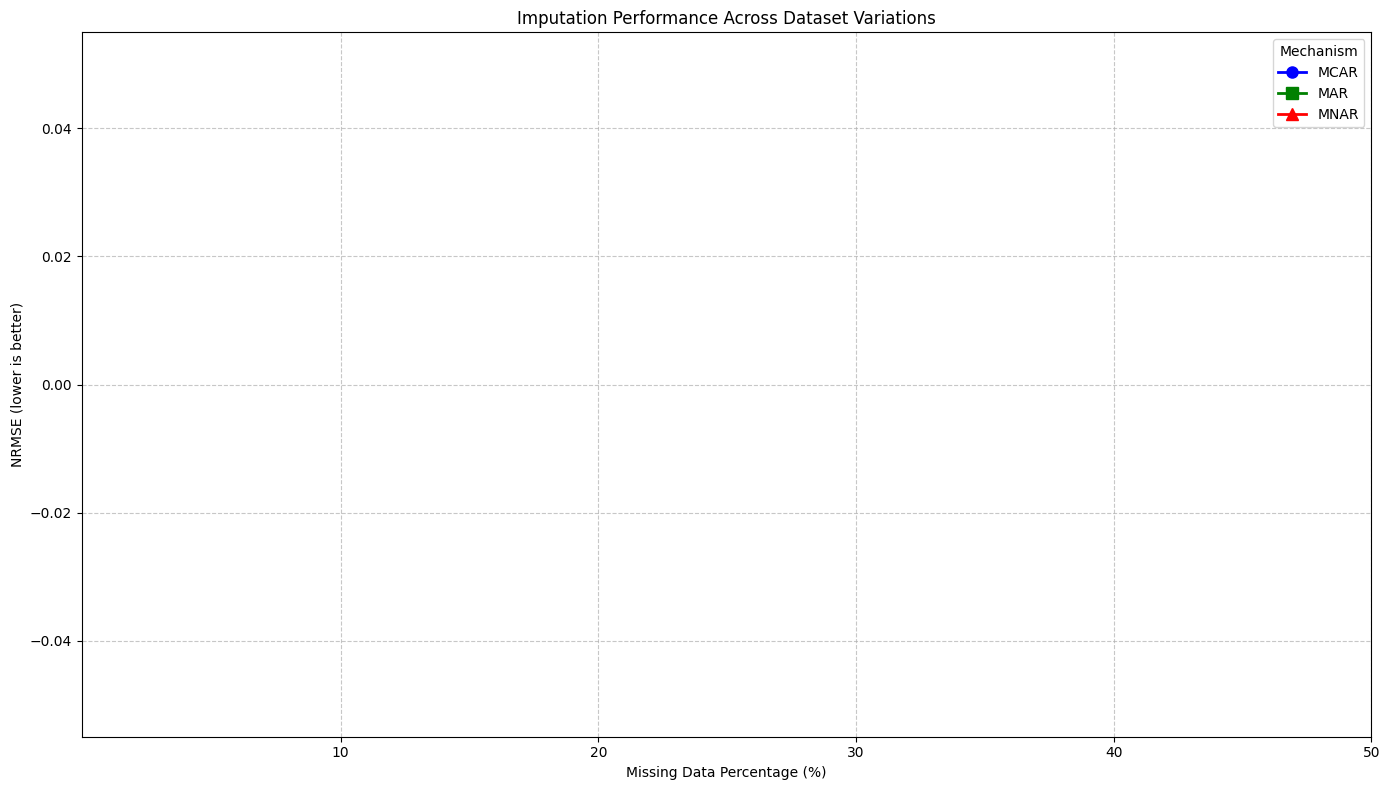


Dataset creation and imputation complete!


In [27]:
# Code to run the dataset creation and imputation (to be added at the end of the notebook)
if __name__ == "__main__":
    # Import json if not already imported
    import json
    
    print("\n=== Creating and Imputing Datasets with Missing Values ===")
    
    # Define the missing percentages to use
    missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Create directory for dataset experiment
    dataset_dir = os.path.join(save_dir, "dataset_experiment")
    os.makedirs(dataset_dir, exist_ok=True)
    
    # Run dataset creation and imputation
    imputation_metrics = create_and_impute_datasets(
        original_data_path=config["data_path"],
        save_dir=dataset_dir,
        model=model,  # Main model
        mnar_model=mnar_model if TRAIN_SPECIALIZED else None,  # Specialized MNAR model if available
        scaler=scaler,  # Data scaler
        missing_percentages=missing_percentages,
        mechanisms=mechanisms
    )
    
    # Create visualization of imputation results across datasets
    plt.figure(figsize=(14, 8))
    
    # Set up colors and markers for each mechanism
    colors = {'MCAR': 'blue', 'MAR': 'green', 'MNAR': 'red'}
    markers = {'MCAR': 'o', 'MAR': 's', 'MNAR': '^'}
    
    # Plot NRMSE for each mechanism and percentage
    for mechanism in mechanisms:
        x_values = [int(pct) for pct in sorted([p for p in imputation_metrics[mechanism].keys()])]
        y_values = [imputation_metrics[mechanism][str(x)]["nrmse"] for x in x_values]
        
        plt.plot(x_values, y_values, 
                 label=f"{mechanism}", 
                 color=colors[mechanism], 
                 marker=markers[mechanism],
                 linewidth=2,
                 markersize=8)
    
    plt.xlabel("Missing Data Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance Across Dataset Variations")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Mechanism")
    plt.xticks(x_values)
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(dataset_dir, "dataset_imputation_summary.png")
    plt.savefig(plot_path)
    print(f"Summary plot saved to {plot_path}")
    plt.show()
    
    print("\nDataset creation and imputation complete!")

## Impute the original dataset

In [28]:
def impute_original_dataset(trained_model, scaler, save_path="imputed_original.csv"):
    """
    Load the original CSV dataset, impute missing values using the pre-trained transformer model,
    and save the imputed dataset.
    
    Args:
        trained_model: The pre-trained imputation model
        scaler: The fitted scaler used during model training
        save_path: Path to save the imputed dataset
    """
    print("\n=== Imputing Original Dataset ===")
    
    # Set model to evaluation mode
    trained_model.eval()
    
    # File path
    original_file_path = "./data/physionet_39_features_only.csv"
    
    # Load the original dataset
    print(f"Loading original dataset from {original_file_path}...")
    df_original = pd.read_csv(original_file_path, index_col=0)
    print(f"Original dataset shape: {df_original.shape}")
    
    # Check for missing values
    missing_count = df_original.isna().sum().sum()
    missing_percentage = (missing_count / (df_original.shape[0] * df_original.shape[1])) * 100
    print(f"Dataset contains {missing_count} missing values ({missing_percentage:.2f}% of all values)")
    
    # Create a copy of the original dataset for imputation
    df_imputed = df_original.copy()
    
    # Extract numerical columns for imputation
    numerical_cols = df_original.select_dtypes(include=['number']).columns
    print(f"Found {len(numerical_cols)} numerical columns")
    
    # Create mask for missing values (True where values are missing)
    missing_mask = df_original[numerical_cols].isna()
    
    # Fill missing values with 0 for initial processing
    df_filled = df_original[numerical_cols].fillna(0)
    
    # Scale the data using the provided scaler
    data_scaled = scaler.transform(df_filled)
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices tensor
    column_indices = torch.arange(data_tensor.shape[1]).to(device)
    
    # Create mask tensor (1 where values are missing, 0 otherwise)
    mask_tensor = torch.tensor(missing_mask.values, dtype=torch.int).to(device)
    
    print("Performing imputation with trained model...")
    
    with torch.no_grad():
        # Get predictions from the model
        imputed_tensor = trained_model(data_tensor, column_indices, mask_tensor)
        
        # Convert to numpy for processing
        imputed_np = imputed_tensor.cpu().numpy()
        
        # Inverse transform to original scale
        imputed_np = scaler.inverse_transform(imputed_np)
        
        # Create a DataFrame from the imputed values
        imputed_df = pd.DataFrame(imputed_np, columns=numerical_cols, index=df_original.index)
        
        # Replace missing values in the original dataframe with imputed values
        for col in numerical_cols:
            if col in df_imputed.columns:
                missing_idx = df_imputed[col].isna()
                df_imputed.loc[missing_idx, col] = imputed_df.loc[missing_idx, col]
    
    # Save the imputed dataset
    print(f"Saving imputed dataset to {save_path}...")
    df_imputed.to_csv(save_path)
    
    # Verification
    missing_after = df_imputed[numerical_cols].isna().sum().sum()
    print(f"Missing values in numerical columns after imputation: {missing_after}")
    
    total_missing_after = df_imputed.isna().sum().sum()
    if total_missing_after > 0:
        print(f"Total missing values after imputation: {total_missing_after}")
        print("Note: Non-numerical columns may still contain missing values")
    else:
        print("All missing values have been successfully imputed")
    
    print("Imputation complete!")
    
    return df_imputed

In [29]:
# Execute the imputation process
if __name__ == "__main__":
    print("\n=== Running Imputation on Original Dataset ===")
    
    # Use the already trained model
    # Assuming 'model' and 'scaler' are the trained model and scaler from earlier in the notebook
    imputed_data = impute_original_dataset(model, scaler, "imputed_original.csv")
    
    # Display sample of the imputed data
    print("\nSample of imputed data:")
    print(imputed_data.head())


=== Running Imputation on Original Dataset ===

=== Imputing Original Dataset ===
Loading original dataset from ./data/physionet_39_features_only.csv...
Original dataset shape: (2008, 38)
Dataset contains 2978 missing values (3.90% of all values)
Found 38 numerical columns
Performing imputation with trained model...


c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Saving imputed dataset to imputed_original.csv...
Missing values in numerical columns after imputation: 0
All missing values have been successfully imputed
Imputation complete!

Sample of imputed data:
                 eye.opening  movement  GCS  lactate.dehydrogenase  \
verbal.response                                                      
5                          4         6   15             294.000000   
5                          4         6   15             203.000000   
5                          4         6   15             137.000000   
5                          4         6   15             340.281525   
5                          4         6   15             295.000000   

                 glutamic.oxaloacetic.transaminase  globulin  total.bilirubin  \
verbal.response                                                                 
5                                        81.000000      23.8             18.3   
5                                        21.000000      25.4    